In [ ]:
library(tidyverse)
library(ggplot2)
library(ncdf4)
library(extRemes)
source("caldat.R")
source("gev_gdp.R")
library(dplyr)
library(patchwork)
library(zoo)
library(gridExtra)
library(scales)
fig_path = '/home/estimr3/lhasbini/ANDRA/R_fig/'
CMIP6Adjust_path = "/home/estimr3/yiou/ANDRA2022/CMIP6_R2D2/GrandEst/"
CMIP6_path = "/home/estimr3/lhasbini/CMIP6/"

In [7]:
# Suppress warning 
original_warn <- options("warn") 
options(warn = -1)               

In [8]:
#### Initializatin of global parameters ####
variable='tasmin'
stations = c('Bure','St Dizier','Cirfontaines')
scenarios = c('historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585')
groups = c('MPI-M', 'AS-RCEC', 'BCC', 'CCCma', 'CNRM-CERFACS', 'CSIRO', 'EC-Earth-Consortium', 'IPSL',  'MRI', 'NOAA-GFDL')  
models = c('MPI-ESM1-2-LR', 'TaiESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'EC-Earth3','IPSL-CM6A-LR', 'MRI-ESM2-0', 'GFDL-ESM4') 

groups_no_GFDL = c('MPI-M', 'AS-RCEC', 'BCC', 'CCCma', 'CNRM-CERFACS', 'CSIRO', 'EC-Earth-Consortium', 'IPSL',  'MRI')  
models_no_GFDL = c('MPI-ESM1-2-LR', 'TaiESM1', 'BCC-CSM2-MR', 'CanESM5', 'CNRM-ESM2-1', 'ACCESS-ESM1-5', 'EC-Earth3','IPSL-CM6A-LR', 'MRI-ESM2-0') 

#### Extract CMIP6 data ####
tas_global = data_CMIP6_fldmean_yearmean_to_df(models, CMIP6_path, 'tas', scenarios, 'Global')
tas_Europe = data_CMIP6_fldmean_yearmean_to_df(models, CMIP6_path, 'tas', scenarios, 'Europe')

tasmax_CMIP6_GE = data_CMIP6_GE_to_df(models, CMIP6_path, 'tasmax', scenarios)
#tasmax_CMIP6_GE.JJA = data_CMIP6_GE_to_df(models, CMIP6_path, 'tasmax', scenarios, season = 'JJA')

TX_CMIP6_GE = data_CMIP_to_varn_max(tasmax_CMIP6_GE)
TX_CMIP6_GE = TX_CMIP6_GE %>% mutate(station='GrandEst')

#### extract Adjust data tasmax, TX ####
tasmax_adjust_stations = data_adjust_to_df(groups, models, CMIP6_Ajust_path_R2D2, 'tasmax', scenarios, stations, 'R2D2')
tasmax_adjust_stations.JJA = data_adjust_to_df(groups, models, CMIP6_Ajust_path_R2D2, 'tasmax', scenarios, stations, 'R2D2', 'JJA')
tasmax_adjust_CDFt_stations = data_adjust_to_df(groups_no_GFDL, models_no_GFDL, paste0(CMIP6_Ajust_path_CDFt, 'tasmax/'), 'tasmax', scenarios, stations, 'CDFt')

#Compute yearly mean temperature
TX_adjust_stations = data_to_varn_max(tasmax_adjust_stations)
TX_adjust_CDFt_stations = data_to_varn_max(tasmax_adjust_CDFt_stations)
#TX_adjust_stations.JJA = data_to_varn_max(tasmax_adjust_stations.JJA)

#### extract Adjust data tasmin, TN ####
tasmin_CMIP6_GE = data_CMIP6_GE_to_df(models, CMIP6_path, 'tasmin', scenarios)
tasmin_CMIP6_GE.DJF = data_CMIP6_GE_to_df(models, CMIP6_path, 'tasmin', scenarios, season = 'DJF')

#TN_CMIP6_GE = data_CMIP_to_varn_min(tasmin_CMIP6_GE)
#TN_CMIP6_GE = TN_CMIP6_GE %>% mutate(station='GrandEst')

tasmin_adjust_stations = data_adjust_to_df(groups, models, CMIP6_Ajust_path_R2D2, 'tasmin', scenarios, stations, 'R2D2')
tasmin_adjust_stations.JJA = data_adjust_to_df(groups, models, CMIP6_Ajust_path_R2D2, 'tasmin', scenarios, stations, 'R2D2', 'JJA')
tasmin_adjust_CDFt_stations = data_adjust_to_df(groups_no_GFDL, models_no_GFDL, paste0(CMIP6_Ajust_path_CDFt, 'tasmin/'), 'tasmin', scenarios, stations, 'CDFt')

#Compute yearly mean temperature
TN_adjust_stations = data_to_varn_min(tasmin_adjust_stations)
TN_adjust_CDFt_stations = data_to_varn_min(tasmin_adjust_CDFt_stations)

#### Historical records & ECS ####
TX_record_stations =data.frame(TX = rep(c(40, 40, 41.4), 4),
                        station = rep(c('Bure', 'Cirfontaines', 'St Dizier'),4), 
                        scenario = c(rep('ssp126', 3), rep('ssp245', 3), rep('ssp370', 3), rep('ssp585', 3)), 
                        CMIP_model=rep(models, each=12))

TN_record_stations = data.frame(TN = rep(rep(c(-19.6,-19.6,-22.5),4),10), 
                                station = rep(rep(c('Bure', 'Cirfontaines', 'St Dizier'),4), 10), 
                        scenario = rep(c(rep('ssp126', 3), rep('ssp245', 3), rep('ssp370', 3), rep('ssp585', 3)), 10), 
                        CMIP_model = rep(models, each=12))

ECS = data.frame(CMIP_model = c('MPI-ESM1-2-LR', 'BCC-CSM2-MR', 'MRI-ESM2-0', 'ACCESS-ESM1-5', 'GFDL-ESM4', 'EC-Earth3', 'IPSL-CM6A-LR', 'CanESM5'), 
                 ECS = c(2.98, 3.04, 3.15, 3.87, 3.9, 4.3, 4.56, 5.62))

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(stations)` instead of `stations` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.


In [9]:
ns_model_GMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_params_GMST.Rda", sep=""))
ns_model_GMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_EMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_params_EMST.Rda", sep=""))
ns_model_EMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_100y_rl_2100_EMST.Rda", sep=""))

#Final after selection procedure
ns_model_GMST_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_params_GMST.Rda", sep=""))
ns_model_GMST_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_EMST_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_params_EMST.Rda", sep=""))
ns_model_EMST_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE HISTORICAL DATA IN THE FIT
ns_model_GMST_no_hist.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_params_GMST.Rda", sep=""))
ns_model_GMST_no_hist.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_EMST_no_hist.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_params_EMST.Rda", sep=""))
ns_model_EMST_no_hist.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE HISTORICAL DATA IN THE FIT
ns_model_GMST_no_hist_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_params_GMST.Rda", sep=""))
ns_model_GMST_no_hist_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_EMST_no_hist_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_params_EMST.Rda", sep=""))
ns_model_EMST_no_hist_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE MAX
ns_model_GMST_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_params_GMST.Rda", sep=""))
ns_model_GMST_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_EMST_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_params_EMST.Rda", sep=""))
ns_model_EMST_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_100y_rl_2100_EMST.Rda", sep=""))

#Final after selection procedure
ns_model_GMST_no_max_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_params_GMST.Rda", sep=""))
ns_model_GMST_no_max_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_EMST_no_max_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_params_EMST.Rda", sep=""))
ns_model_EMST_no_max_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_100y_rl_2100_EMST.Rda", sep=""))

In [10]:
ns_model_tasmin_GMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmin_adjust_params_GMST.Rda", sep=""))
ns_model_tasmin_GMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_tasmin_EMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmin_adjust_params_EMST.Rda", sep=""))
ns_model_tasmin_EMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))

#Final after selection procedure
ns_model_tasmin_GMST_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_tasmin_adjust_params_GMST.Rda", sep=""))
ns_model_tasmin_GMST_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_tasmin_EMST_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_tasmin_adjust_params_EMST.Rda", sep=""))
ns_model_tasmin_EMST_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE HISTORICAL DATA IN THE FIT
ns_model_tasmin_GMST_no_hist.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmin_adjust_params_GMST.Rda", sep=""))
ns_model_tasmin_GMST_no_hist.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_tasmin_EMST_no_hist.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmin_adjust_params_EMST.Rda", sep=""))
ns_model_tasmin_EMST_no_hist.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))
# 
# #WITHOUT THE HISTORICAL DATA IN THE FIT
# ns_model_tasmin_GMST_no_hist_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmin_adjust_params_GMST.Rda", sep=""))
# ns_model_tasmin_GMST_no_hist_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
# ns_model_tasmin_EMST_no_hist_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmin_adjust_params_EMST.Rda", sep=""))
# ns_model_tasmin_EMST_no_hist_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE MAX
ns_model_tasmin_GMST_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_max_tasmin_adjust_params_GMST.Rda", sep=""))
ns_model_tasmin_GMST_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_max_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_tasmin_EMST_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_max_tasmin_adjust_params_EMST.Rda", sep=""))
ns_model_tasmin_EMST_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_max_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))
# 
# #Final after selection procedure
# ns_model_tasmin_GMST_no_max_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmin_adjust_params_GMST.Rda", sep=""))
# ns_model_tasmin_GMST_no_max_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
# ns_model_tasmin_EMST_no_max_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmin_adjust_params_EMST.Rda", sep=""))
# ns_model_tasmin_EMST_no_max_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE MAX
ns_model_tasmin_GMST_no_hist_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_no_max_tasmin_adjust_params_GMST.Rda", sep=""))
ns_model_tasmin_GMST_no_hist_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_no_max_tasmin_adjust_100y_rl_2100_GMST.Rda", sep=""))
ns_model_tasmin_EMST_no_hist_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_no_max_tasmin_adjust_params_EMST.Rda", sep=""))
ns_model_tasmin_EMST_no_hist_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_no_max_tasmin_adjust_100y_rl_2100_EMST.Rda", sep=""))

In [11]:
ns_model_CDFt_GMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_CDFt_params_GMST.Rda", sep=""))
ns_model_CDFt_GMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_CDFt_100y_rl_2100_GMST.Rda", sep=""))
ns_model_CDFt_EMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_CDFt_params_EMST.Rda", sep=""))
ns_model_CDFt_EMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmax_adjust_CDFt_100y_rl_2100_EMST.Rda", sep=""))

#Final after selection procedure
ns_model_CDFt_GMST_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_CDFt_params_GMST.Rda", sep=""))
ns_model_CDFt_GMST_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_CDFt_100y_rl_2100_GMST.Rda", sep=""))
ns_model_CDFt_EMST_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_CDFt_params_EMST.Rda", sep=""))
ns_model_CDFt_EMST_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_tasmax_adjust_CDFt_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE HISTORICAL DATA IN THE FIT
# ns_model_CDFt_GMST_no_hist.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_CDFt_params_GMST.Rda", sep=""))
# ns_model_CDFt_GMST_no_hist.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_CDFt_100y_rl_2100_GMST.Rda", sep=""))
# ns_model_CDFt_EMST_no_hist.gev.params = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_CDFt_params_EMST.Rda", sep=""))
# ns_model_CDFt_EMST_no_hist.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_hist_tasmax_adjust_CDFt_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE HISTORICAL DATA IN THE FIT
# ns_model_CDFt_GMST_no_hist_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_CDFt_params_GMST.Rda", sep=""))
# ns_model_CDFt_GMST_no_hist_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_CDFt_100y_rl_2100_GMST.Rda", sep=""))
# ns_model_CDFt_EMST_no_hist_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_CDFt_params_EMST.Rda", sep=""))
# ns_model_CDFt_EMST_no_hist_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_hist_tasmax_adjust_CDFt_100y_rl_2100_EMST.Rda", sep=""))

#WITHOUT THE MAX
ns_model_CDFt_GMST_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_CDFt_params_GMST.Rda", sep=""))
ns_model_CDFt_GMST_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_CDFt_100y_rl_2100_GMST.Rda", sep=""))
ns_model_CDFt_EMST_no_max.gev.params = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_CDFt_params_EMST.Rda", sep=""))
ns_model_CDFt_EMST_no_max.gev.rl = readRDS(file=paste(data_path, "gev_ns_no_max_tasmax_adjust_CDFt_100y_rl_2100_EMST.Rda", sep=""))

#Final after selection procedure
ns_model_CDFt_GMST_no_max_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_CDFt_params_GMST.Rda", sep=""))
ns_model_CDFt_GMST_no_max_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_CDFt_100y_rl_2100_GMST.Rda", sep=""))
ns_model_CDFt_EMST_no_max_final.gev.params = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_CDFt_params_EMST.Rda", sep=""))
ns_model_CDFt_EMST_no_max_final.gev.rl = readRDS(file=paste(data_path, "gev_final_ns_no_max_tasmax_adjust_CDFt_100y_rl_2100_EMST.Rda", sep=""))

In [12]:
ns_model_CMIP_GMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmax_CMIP_params_GMST.Rda", sep=""))
ns_model_CMIP_GMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmax_CMIP_100y_rl_2100_GMST.Rda", sep=""))
ns_model_CMIP_EMST.gev.params = readRDS(file=paste(data_path, "gev_ns_tasmax_CMIP_params_EMST.Rda", sep=""))
ns_model_CMIP_EMST.gev.rl = readRDS(file=paste(data_path, "gev_ns_tasmax_CMIP_100y_rl_2100_EMST.Rda", sep=""))

In [13]:
ns_models = c('M110','M000','M-100', 'M-110', 'M100')
#ns_models = c('M000', 'M100', 'M110')
alpha_llh = 0.1
return_horizon = c(2100)
return_period= 100

spar = 0.9
tas_global_spline = data.frame(matrix(ncol = ncol(tas_global)+1, nrow = 0))
colnames(tas_global_spline) = append(colnames(tas_global),c('covariate'))
for(mod in models){
  for(sc in c('ssp126', 'ssp245', 'ssp370', 'ssp585')){
    data_loop = tas_global%>%filter(scenario%in%c('historical', sc), CMIP_model==mod)
    data_loop = data_loop %>% mutate(var = scale(var))
    model_spline_TX_GMST_loop = smooth.spline(x=data_loop$year, y = data_loop$var, spar=spar)
    data_loop$covariate  = predict(model_spline_TX_GMST_loop, data_loop$year)$y
    data_loop$scenario = sc
    tas_global_spline = rbind(tas_global_spline, data_loop)
  }
  sc = 'historical'
  data_loop = tas_global%>%filter(scenario== sc, CMIP_model==mod)
  data_loop_scenarios = tas_global_spline%>%filter(scenario%in%c('ssp126', 'ssp245', 'ssp370', 'ssp585'), CMIP_model==mod, year<2015)
  data_loop = merge(data_loop, aggregate(covariate~year, data_loop_scenarios, mean))
  data_loop$scenario=sc
  tas_global_spline = rbind(tas_global_spline, data_loop)
}

spar = 0.9
tas_europe_spline = data.frame(matrix(ncol = ncol(tas_Europe)+1, nrow = 0))
colnames(tas_europe_spline) = append(colnames(tas_Europe),c('covariate'))
for(mod in models){
  for(sc in c('ssp126', 'ssp245', 'ssp370', 'ssp585')){
    data_loop = tas_Europe%>%filter(scenario%in%c('historical', sc), CMIP_model==mod)
    data_loop = data_loop %>% mutate(var = scale(var))
    model_spline_TX_EMST_loop = smooth.spline(x=data_loop$year, y = data_loop$var, spar=spar)
    data_loop$covariate  = predict(model_spline_TX_EMST_loop, data_loop$year)$y
    data_loop$scenario = sc
    tas_europe_spline = rbind(tas_europe_spline, data_loop)
  }
  sc = 'historical'
  data_loop = tas_Europe%>%filter(scenario== sc, CMIP_model==mod)
  data_loop_scenarios = tas_europe_spline%>%filter(scenario%in%c('ssp126', 'ssp245', 'ssp370', 'ssp585'), CMIP_model==mod, year<2015)
  data_loop = merge(data_loop, aggregate(covariate~year, data_loop_scenarios, mean))
  data_loop$scenario=sc
  tas_europe_spline = rbind(tas_europe_spline, data_loop)
}

In [14]:
tas_global_spline_mutate = tas_global_spline %>% select(-var)
tas_europe_spline_mutate = tas_europe_spline %>% select(-var)
TX_adjust_stations_GMST = merge(TX_adjust_stations, tas_global_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TX_adjust_stations_EMST = merge(TX_adjust_stations, tas_europe_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TX_CMIP_GE_GMST = merge(TX_CMIP6_GE, tas_global_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TX_CMIP_GE_EMST = merge(TX_CMIP6_GE, tas_europe_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TX_adjust_CDFt_stations_GMST = merge(TX_adjust_CDFt_stations, tas_global_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TX_adjust_CDFt_stations_EMST = merge(TX_adjust_CDFt_stations, tas_europe_spline_mutate, by=c("year", "scenario", "CMIP_model"))


TN_adjust_stations_GMST = merge(TN_adjust_stations, tas_global_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TN_adjust_stations_EMST = merge(TN_adjust_stations, tas_europe_spline_mutate, by=c("year", "scenario", "CMIP_model"))
#tasmax_adjust_stations_global_tas_mean_to_covariate.JJA = merge(spline_threshold(tasmax_adjust_stations.JJA, percentile_threshold = 0.95), tas_global, by=c("year", "scenario", "CMIP_model"))
#tasmax_adjust_stations_global_tas_mean_to_covariate_CMIP.JJA = merge(spline_threshold(tasmax_CMIP6_GE.JJA, percentile_threshold = 0.95), tas_global, by=c("year", "scenario", "CMIP_model"))

#{r, Remove models non working for GEV computation}
TX_adjust_stations_GMST = subset(TX_adjust_stations_GMST, CMIP_model!='MPI-ESM1-2-LR' | scenario!='ssp126'| station != 'Bure')
TX_adjust_stations_EMST = subset(TX_adjust_stations_EMST, CMIP_model!='MPI-ESM1-2-LR' | scenario!='ssp126'| station != 'Bure')

In [15]:
#Selection process of CMIP data
ns_model_CMIP_GMST_final.gev = selection_models(tasmax_CMIP6_GE, TX_CMIP_GE_GMST, ns_model_CMIP_GMST.gev.params, ns_rl = ns_model_CMIP_GMST.gev.rl, variable)
ns_model_CMIP_GMST_final.gev.params = ns_model_CMIP_GMST_final.gev$params
ns_model_CMIP_GMST_final.gev.rl = ns_model_CMIP_GMST_final.gev$return_levels

ns_model_CMIP_EMST_final.gev = selection_models(tasmax_CMIP6_GE, TX_CMIP_GE_EMST, ns_model_CMIP_EMST.gev.params, ns_rl = ns_model_CMIP_EMST.gev.rl, variable)
ns_model_CMIP_EMST_final.gev.params = ns_model_CMIP_EMST_final.gev$params
ns_model_CMIP_EMST_final.gev.rl = ns_model_CMIP_EMST_final.gev$return_levels

In [16]:
variable='tasmin'

#Regular
ns_model_tasmin_GMST_final.gev = selection_models(tasmin_adjust_stations, TN_adjust_stations_GMST, ns_model_tasmin_GMST.gev.params, ns_rl = ns_model_tasmin_GMST.gev.rl, variable)
ns_model_tasmin_GMST_final.gev.params = ns_model_tasmin_GMST_final.gev$params
ns_model_tasmin_GMST_final.gev.rl = ns_model_tasmin_GMST_final.gev$return_levels

ns_model_tasmin_EMST_final.gev = selection_models(tasmin_adjust_stations, TN_adjust_stations_EMST, ns_model_tasmin_EMST.gev.params, ns_rl = ns_model_tasmin_EMST.gev.rl, variable)
ns_model_tasmin_EMST_final.gev.params = ns_model_tasmin_EMST_final.gev$params
ns_model_tasmin_EMST_final.gev.rl = ns_model_tasmin_EMST_final.gev$return_levels

# saveRDS(ns_model_tasmin_GMST_final.gev.params, file=paste(data_path, "gev_final_ns_",variable,"_adjust_params_GMST.Rda", sep=""))
# saveRDS(ns_model_tasmin_GMST_final.gev.rl, file=paste(data_path, "gev_final_ns_",variable,"_adjust_",return_period,"y_rl_",return_horizon[1],"_GMST.Rda", sep=""))

# saveRDS(ns_model_tasmin_EMST_final.gev.params, file=paste(data_path, "gev_final_ns_",variable,"_adjust_params_EMST.Rda", sep=""))
# saveRDS(ns_model_tasmin_EMST_final.gev.rl, file=paste(data_path, "gev_final_ns_",variable,"_adjust_",return_period,"y_rl_",return_horizon[1],"_EMST.Rda", sep=""))

#No max
ns_model_tasmin_GMST_no_max_final.gev = selection_models(tasmin_adjust_stations, TN_adjust_stations_GMST, ns_model_tasmin_GMST_no_max.gev.params, ns_rl = ns_model_tasmin_GMST_no_max.gev.rl, variable)
ns_model_tasmin_GMST_no_max_final.gev.params = ns_model_tasmin_GMST_no_max_final.gev$params
ns_model_tasmin_GMST_no_max_final.gev.rl = ns_model_tasmin_GMST_no_max_final.gev$return_levels

ns_model_tasmin_EMST_no_max_final.gev = selection_models(tasmin_adjust_stations, TN_adjust_stations_EMST, ns_model_tasmin_EMST_no_max.gev.params, ns_rl = ns_model_tasmin_EMST_no_max.gev.rl, variable)
ns_model_tasmin_EMST_no_max_final.gev.params = ns_model_tasmin_EMST_no_max_final.gev$params
ns_model_tasmin_EMST_no_max_final.gev.rl = ns_model_tasmin_EMST_no_max_final.gev$return_levels

# saveRDS(ns_model_tasmin_GMST_no_max_final.gev.params, file=paste(data_path, "gev_final_ns_no_max_",variable,"_adjust_params_GMST.Rda", sep=""))
# saveRDS(ns_model_tasmin_GMST_no_max_final.gev.rl, file=paste(data_path, "gev_final_ns_no_max_",variable,"_adjust_",return_period,"y_rl_",return_horizon[1],"_GMST.Rda", sep=""))

# saveRDS(ns_model_tasmin_EMST_no_max_final.gev.params, file=paste(data_path, "gev_final_ns_no_max_",variable,"_adjust_params_EMST.Rda", sep=""))
# saveRDS(ns_model_tasmin_EMST_no_max_final.gev.rl, file=paste(data_path, "gev_final_ns_no_max_",variable,"_adjust_",return_period,"y_rl_",return_horizon[1],"_EMST.Rda", sep=""))

In [17]:
# for(CMIP_mod in models){
#   for(sc in scenarios){
#   p =ggplot() +
#     geom_point(aes(x=var, y=covariate), 
#                data = TX_adjust_stations_GMST %>%filter(CMIP_model==CMIP_mod, station=='St Dizier', scenario==sc)) +
#   labs(x='Covariate [°C]', 
#        y='Temperature [°C]', 
#        title = paste('Tasmax fct of GMST',CMIP_mod,'St Dizier', sc))
#   plot(p)
#   }
# }

In [18]:
#```{r, Tasmax, GEV regression}
#Original GEV computation
ns_model_GMST.evol = gev_regression(ns_model_GMST.gev.params, TX_adjust_stations_GMST)
ns_model_EMST.evol = gev_regression(ns_model_EMST.gev.params, TX_adjust_stations_EMST)

ns_model_CMIP_GMST.evol = gev_regression(ns_model_CMIP_GMST.gev.params, TX_CMIP_GE_GMST)
ns_model_CMIP_EMST.evol = gev_regression(ns_model_CMIP_EMST.gev.params, TX_CMIP_GE_EMST)

ns_model_CDFt_GMST.evol = gev_regression(ns_model_CDFt_GMST.gev.params, TX_adjust_CDFt_stations_GMST)
ns_model_CDFt_EMST.evol = gev_regression(ns_model_CDFt_EMST.gev.params, TX_adjust_CDFt_stations_EMST)

#Computation without hist 
ns_model_GMST_no_hist.evol = gev_regression(ns_model_GMST_no_hist.gev.params, TX_adjust_stations_GMST)
ns_model_EMST_no_hist.evol = gev_regression(ns_model_EMST_no_hist.gev.params, TX_adjust_stations_EMST)

#Computation without max
ns_model_GMST_no_max.evol = gev_regression(ns_model_GMST_no_max.gev.params, TX_adjust_stations_GMST)
ns_model_EMST_no_max.evol = gev_regression(ns_model_EMST_no_max.gev.params, TX_adjust_stations_EMST)

ns_model_CDFt_GMST_no_max.evol = gev_regression(ns_model_CDFt_GMST_no_max.gev.params, TX_adjust_CDFt_stations_GMST)
ns_model_CDFt_EMST_no_max.evol = gev_regression(ns_model_CDFt_EMST_no_max.gev.params, TX_adjust_CDFt_stations_EMST)

In [19]:
#```{r, Tasmax, GEV regression}
#Original GEV computation
ns_model_GMST.tasmin.evol = gev_regression(ns_model_tasmin_GMST.gev.params, TN_adjust_stations_GMST)
ns_model_EMST.tasmin.evol = gev_regression(ns_model_tasmin_EMST.gev.params, TN_adjust_stations_EMST)

#Computation without max
ns_model_GMST_no_max.tasmin.evol = gev_regression(ns_model_tasmin_GMST_no_max.gev.params, TN_adjust_stations_GMST)
ns_model_EMST_no_max.tasmin.evol = gev_regression(ns_model_tasmin_EMST_no_max.gev.params, TN_adjust_stations_EMST)

In [20]:
tasmax_adjust_stations_no_max = data.frame(tasmax_adjust_stations)
tasmax_adjust_stations_max = data.frame(matrix(ncol = ncol(tasmax_adjust_stations_no_max), nrow = 0))
colnames(tasmax_adjust_stations_max) = colnames(tasmax_adjust_stations_no_max)
tasmax_adjust_stations_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmax_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

#tasmax_adjust_stations_no_max.JJA = data.frame(tasmax_adjust_stations.JJA)
#tasmax_adjust_stations_max.JJA = data.frame(matrix(ncol = ncol(tasmax_adjust_stations_no_max.JJA), nrow = 0))
#colnames(tasmax_adjust_stations_max.JJA) = colnames(tasmax_adjust_stations_no_max.JJA)

TX_adjust_stations_no_max = data.frame(TX_adjust_stations)
TX_adjust_stations_max = data.frame(matrix(ncol = ncol(TX_adjust_stations_no_max), nrow = 0))
colnames(TX_adjust_stations_max) = colnames(TX_adjust_stations_no_max)
TX_adjust_stations_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TX_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in stations){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmax_adjust_stations_no_max$var == max(tasmax_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmax_adjust_stations_no_max$CMIP_model == CMIP_mod & tasmax_adjust_stations_no_max$station ==st & tasmax_adjust_stations_no_max$scenario==sc)
    tasmax_adjust_stations_max = rbind(tasmax_adjust_stations_max, tasmax_adjust_stations_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmax_adjust_stations_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmax_adjust_stations_no_max$station == st & 
                               tasmax_adjust_stations_no_max$scenario == sc &
                               tasmax_adjust_stations_no_max$CMIP_model == CMIP_mod &
                               tasmax_adjust_stations_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmax_adjust_stations_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TX_max_loop = which(TX_adjust_stations_no_max$var == max(TX_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TX_adjust_stations_no_max$CMIP_model == CMIP_mod & TX_adjust_stations_no_max$station ==st & TX_adjust_stations_no_max$scenario==sc)
    TX_adjust_stations_max = rbind(TX_adjust_stations_max, TX_adjust_stations_no_max[c(TX_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TX_adjust_stations_no_max[c(TX_max_loop), 'var'] = NaN
    
    diff_loop = max(TX_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TX_adjust_stations_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TX_adjust_stations_diff_max = rbind(TX_adjust_stations_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

In [21]:
#```{r, compute dataframes without yearly and daily maximum, CDFt}
tasmax_adjust_CDFt_stations_no_max = data.frame(tasmax_adjust_CDFt_stations)
tasmax_adjust_CDFt_stations_max = data.frame(matrix(ncol = ncol(tasmax_adjust_CDFt_stations_no_max), nrow = 0))
colnames(tasmax_adjust_CDFt_stations_max) = colnames(tasmax_adjust_CDFt_stations_no_max)
tasmax_adjust_CDFt_stations_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmax_adjust_CDFt_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

#tasmax_adjust_stations_no_max.JJA = data.frame(tasmax_adjust_stations.JJA)
#tasmax_adjust_stations_max.JJA = data.frame(matrix(ncol = ncol(tasmax_adjust_stations_no_max.JJA), nrow = 0))
#colnames(tasmax_adjust_stations_max.JJA) = colnames(tasmax_adjust_stations_no_max.JJA)

TX_adjust_CDFt_stations_no_max = data.frame(TX_adjust_CDFt_stations)
TX_adjust_CDFt_stations_max = data.frame(matrix(ncol = ncol(TX_adjust_CDFt_stations_no_max), nrow = 0))
colnames(TX_adjust_CDFt_stations_max) = colnames(TX_adjust_CDFt_stations_no_max)
TX_adjust_CDFt_stations_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TX_adjust_CDFt_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models_no_GFDL){
  for(sc in scenarios){
  for(st in stations){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmax_adjust_CDFt_stations_no_max$var == max(tasmax_adjust_CDFt_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmax_adjust_CDFt_stations_no_max$CMIP_model == CMIP_mod & tasmax_adjust_CDFt_stations_no_max$station ==st & tasmax_adjust_CDFt_stations_no_max$scenario==sc)
    tasmax_adjust_CDFt_stations_max = rbind(tasmax_adjust_CDFt_stations_max, tasmax_adjust_CDFt_stations_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmax_adjust_CDFt_stations_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmax_adjust_CDFt_stations_no_max$station == st & 
                               tasmax_adjust_CDFt_stations_no_max$scenario == sc &
                               tasmax_adjust_CDFt_stations_no_max$CMIP_model == CMIP_mod &
                               tasmax_adjust_CDFt_stations_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmax_adjust_CDFt_stations_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TX_max_loop = which(TX_adjust_CDFt_stations_no_max$var == max(TX_adjust_CDFt_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TX_adjust_CDFt_stations_no_max$CMIP_model == CMIP_mod & TX_adjust_CDFt_stations_no_max$station ==st & TX_adjust_CDFt_stations_no_max$scenario==sc)
    TX_adjust_CDFt_stations_max = rbind(TX_adjust_CDFt_stations_max, TX_adjust_CDFt_stations_no_max[c(TX_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TX_adjust_CDFt_stations_no_max[c(TX_max_loop), 'var'] = NaN
    
    diff_loop = max(TX_adjust_CDFt_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TX_adjust_CDFt_stations_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TX_adjust_CDFt_stations_diff_max = rbind(TX_adjust_CDFt_stations_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

In [22]:
tasmax_CMIP6_GE_no_max = data.frame(tasmax_CMIP6_GE)
tasmax_CMIP6_GE_max = data.frame(matrix(ncol = ncol(tasmax_CMIP6_GE_no_max), nrow = 0))
colnames(tasmax_CMIP6_GE_max) = colnames(tasmax_CMIP6_GE_no_max)
tasmax_CMIP6_GE_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmax_CMIP6_GE_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

TX_CMIP6_GE_no_max = data.frame(TX_CMIP6_GE)
TX_CMIP6_GE_max = data.frame(matrix(ncol = ncol(TX_CMIP6_GE_no_max), nrow = 0))
colnames(TX_CMIP6_GE_max) = colnames(TX_CMIP6_GE_no_max)
TX_CMIP6_GE_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TX_CMIP6_GE_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in c('GrandEst')){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmax_CMIP6_GE_no_max$var == max(tasmax_CMIP6_GE %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmax_CMIP6_GE_no_max$CMIP_model == CMIP_mod & tasmax_CMIP6_GE_no_max$station ==st & tasmax_CMIP6_GE_no_max$scenario==sc)
    tasmax_CMIP6_GE_max = rbind(tasmax_CMIP6_GE_max, tasmax_CMIP6_GE_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmax_CMIP6_GE_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmax_CMIP6_GE_no_max$station == st & 
                               tasmax_CMIP6_GE_no_max$scenario == sc &
                               tasmax_CMIP6_GE_no_max$CMIP_model == CMIP_mod &
                               tasmax_CMIP6_GE_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmax_CMIP6_GE_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TX_max_loop = which(TX_CMIP6_GE_no_max$var == max(TX_CMIP6_GE %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TX_CMIP6_GE_no_max$CMIP_model == CMIP_mod & TX_CMIP6_GE_no_max$station ==st & TX_CMIP6_GE_no_max$scenario==sc)
    TX_CMIP6_GE_max = rbind(TX_CMIP6_GE_max, TX_CMIP6_GE_no_max[c(TX_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TX_CMIP6_GE_no_max[c(TX_max_loop), 'var'] = NaN
    
    diff_loop = max(TX_CMIP6_GE %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TX_CMIP6_GE_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TX_CMIP6_GE_diff_max = rbind(TX_CMIP6_GE_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

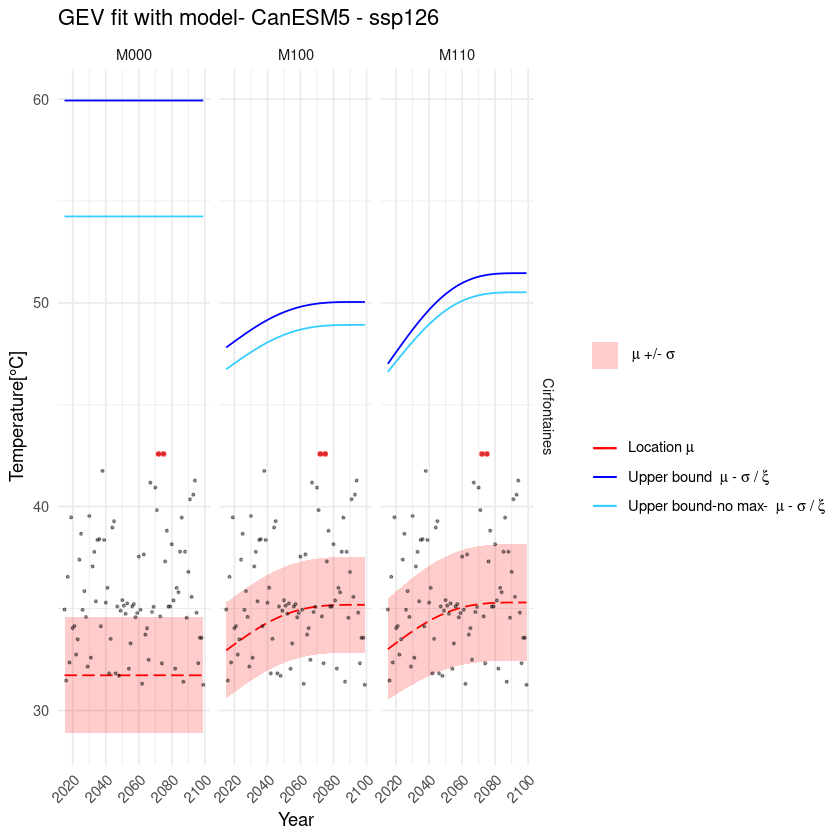

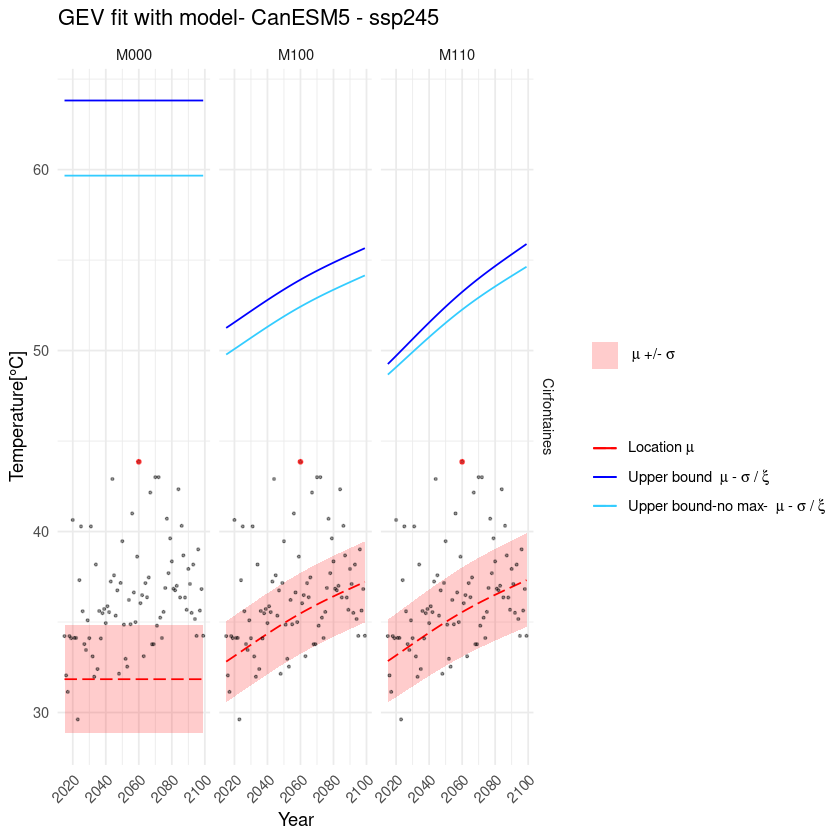

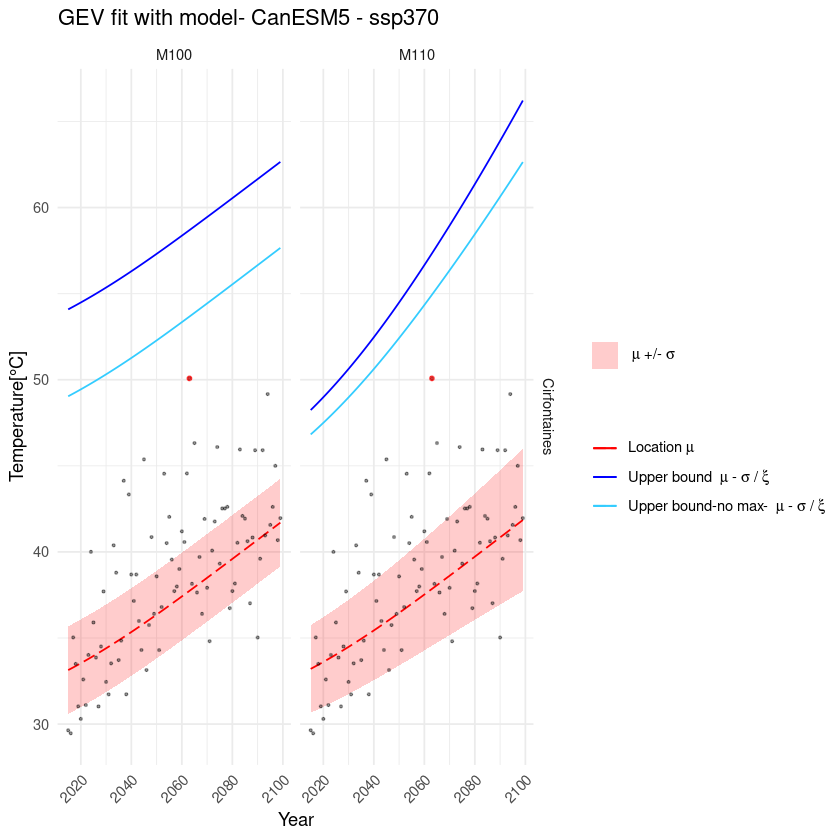

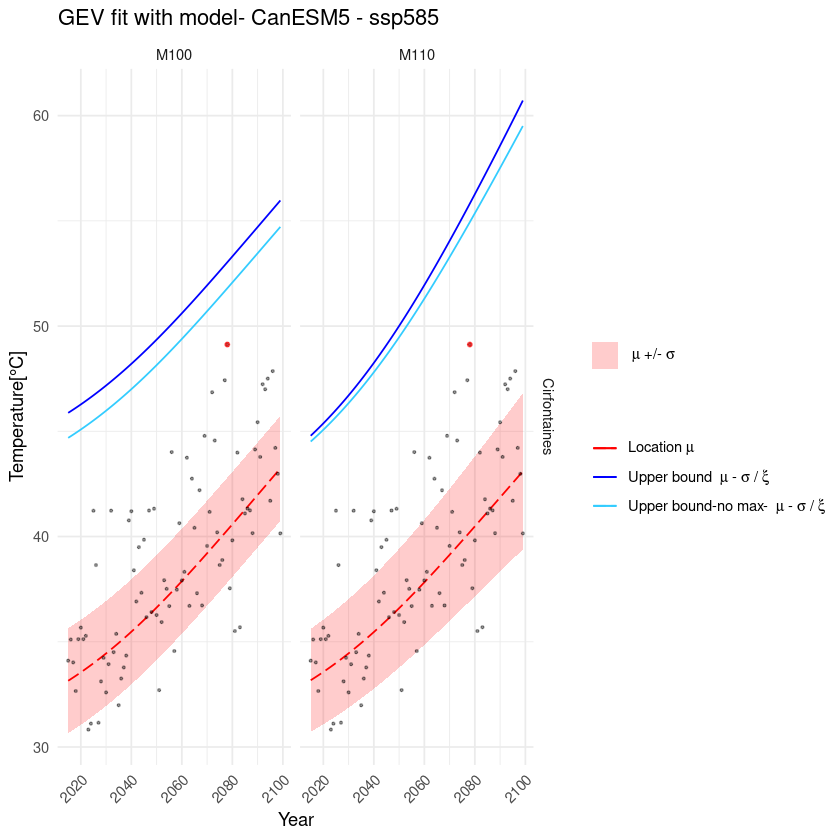

In [25]:
#```{r, Plot data with fit from Adjusted GEV-GMST}
ns_mod_loop = c('M000', 'M100', 'M110')

# Change the station
st = c('Cirfontaines')

#Change the models 
for(CMIP_mod in c('CanESM5')){
  scenarios_loop = Reduce(intersect, list(v1 = unique(ns_model_GMST.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario)), 
                                          v2 = unique(ns_model_GMST_no_max.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario)), 
                                          v3 = unique(ns_model_GMST_no_hist.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario))))
  for(sc in scenarios_loop[[1]]){
  ns_model_loop.evol = ns_model_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_loop_no_max.evol = ns_model_GMST_no_max.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_loop_no_hist.evol = ns_model_GMST_no_hist.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  #ns_model_loop_2.evol = ns_model_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model==ns_mod_2)
  #print(head(ns_model_loop.evol))
  p=ggplot() +
    geom_ribbon(aes(x=year, ymin=loc-scale, ymax=loc+scale, fill='GEV confidence interval'),alpha=0.2, data =ns_model_loop.evol) +
    #geom_ribbon(aes(x=year, ymin=loc_low-scale_high, ymax=loc_high+scale_high, fill='97.5% confidence interval'),alpha=0.2, data =ns_model_loop.evol) +
    geom_line(aes(x=year, y=loc, colour='Black'), linetype = 'longdash', data=ns_model_loop.evol) +
    #geom_line(aes(x=year, y=loc, colour='Loc 2'), linetype = 'longdash', data=ns_model_loop_no_hist.evol) +
    geom_line(aes(x=year, y=upper_bound, color='Upper bound'), data=ns_model_loop.evol) +
    geom_line(aes(x=year, y=upper_bound, color='Upper bound 2'), data=ns_model_loop_no_max.evol) +
    #geom_line(aes(x=year, y=upper_bound, color='Upper bound 3'), data=ns_model_loop_no_hist.evol) +
    #geom_ribbon(aes(x=year, ymin=upper_bound_low, ymax=upper_bound_high, fill='Upper bound 95% confidence interval'),alpha=0.4, data =ns_model_loop.evol) +
    geom_point(aes(x=year, y=var), alpha=0.4, size=0.5, data = TX_adjust_stations_GMST %>% filter(CMIP_model==CMIP_mod, scenario%in%c(sc), station %in% st))+
    geom_point(aes(x=year, y=var), color='#FF0000', alpha=0.6, size=1, data = TX_adjust_stations_max %>% filter(CMIP_model==CMIP_mod, scenario==sc, station %in% st)) +
    theme_minimal() + 
    theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) +
    #ylim(0,80) +
    #scale_y_continuous(trans='log10') +
    #scale_y_log10() +
    #facet_wrap(~ns_model+station, scale='free') +
    facet_grid(row=vars(station), cols=vars(ns_model), scale='free') +
    labs(title=paste('GEV fit with model-',CMIP_mod, '-', sc), 
         x='Year',
         y='Temperature[°C]', 
         fill='', 
         colour='') +
    scale_fill_manual(values=c('#FF0000', '#0000FF'), labels=list(bquote(~mu~"+/-"~sigma), bquote(" Upper bound")))+
    scale_color_manual(values = c('#FF0000', '#0000FF', '#33ccff', '#00ff00'), labels=list(bquote("Location "*mu), bquote("Upper bound "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max- "~mu~ "-" ~sigma~"/"~xi), "Upper bound-no historical"))
  print(p)
  #ggsave(paste(fig_path,"data_and_gev_GMST_fit_", CMIP_mod, "_", sc, "_", st, ".png", sep=""), width=8, height=5)
}
}

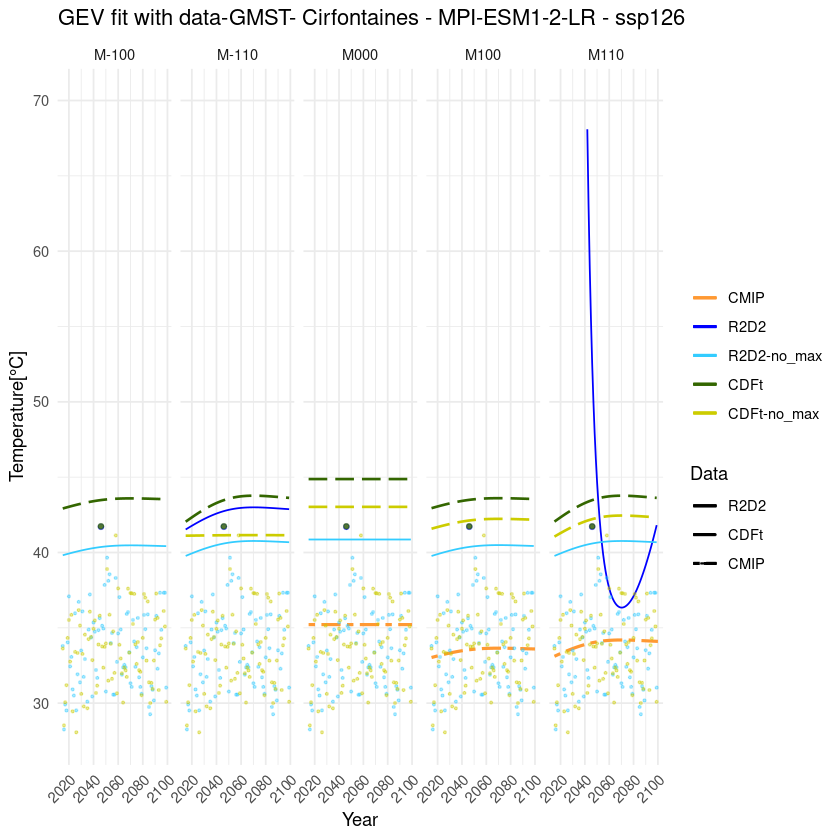

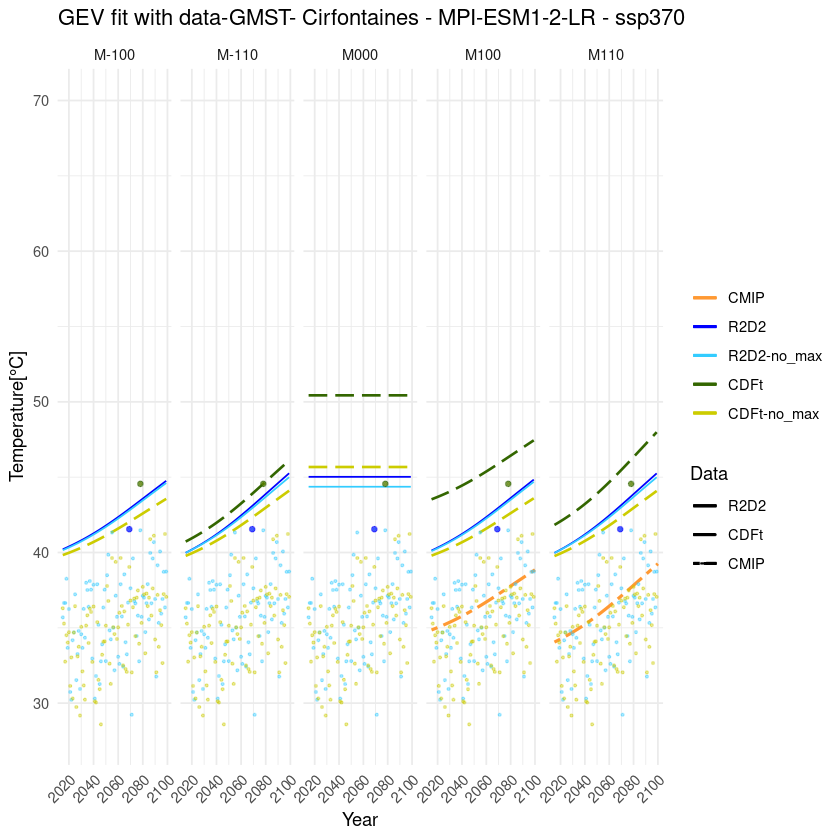

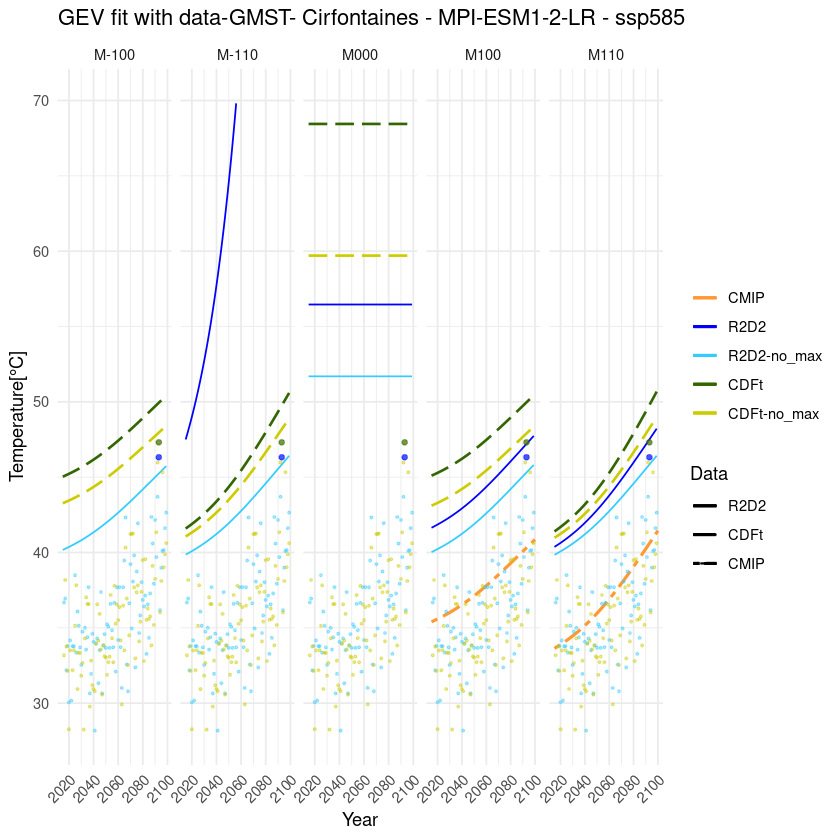

In [21]:
#```{r, Plot data with fit from R2D2, CDFt, CMIP GEV-GMST }
ns_mod_loop = c('M000', 'M100', 'M110', 'M-100', 'M-110')
st = c('Cirfontaines')
for(CMIP_mod in c('MPI-ESM1-2-LR')){
  scenarios_loop = Reduce(intersect, list(v1 = unique(ns_model_GMST.evol%>%filter(CMIP_model==CMIP_mod, station %in% st)%>%select(scenario)), 
                                          v2 = unique(ns_model_GMST_no_max.evol%>%filter(CMIP_model==CMIP_mod, station %in% st)%>%select(scenario)), 
                                          v3 = unique(ns_model_CDFt_GMST.evol%>%filter(CMIP_model==CMIP_mod, station %in% st)%>%select(scenario)), 
                                          v4 = unique(ns_model_CDFt_GMST_no_max.evol%>%filter(CMIP_model==CMIP_mod, station %in% st)%>%select(scenario)), 
                                          v5 = unique(ns_model_CMIP_GMST.evol%>%filter(CMIP_model==CMIP_mod)%>%select(scenario))))
  for(sc in scenarios_loop[[1]]){
  ns_model_loop_GMST.evol = ns_model_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_loop_no_max_GMST.evol = ns_model_GMST_no_max.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_CDFt_loop_GMST.evol = ns_model_CDFt_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_CDFt_loop_no_max_GMST.evol = ns_model_CDFt_GMST_no_max.evol%>%filter(CMIP_model==CMIP_mod, scenario==sc, ns_model%in%ns_mod_loop, station%in%st)
  ns_model_CMIP_loop_GMST.evol = ns_model_CMIP_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop)

  p=ggplot() +
    # geom_ribbon(aes(x=year, ymin=loc-scale, ymax=loc+scale, fill='GEV confidence interval'),alpha=0.2, data =ns_model_loop_GMST.evol) +
    # geom_line(aes(x=year, y=loc, colour='Loc_GMST', linetype='GMST'), data=ns_model_loop_GMST.evol) +
    # geom_ribbon(aes(x=year, ymin=loc-scale, ymax=loc+scale, fill='GEV confidence interval'),alpha=0.2, data =ns_model_loop_EMST.evol) +
    # geom_line(aes(x=year, y=loc, colour='Loc_EMST', linetype='EMST'), data=ns_model_loop_EMST.evol) +
    geom_line(aes(x=year, y=upper_bound, color='R2D2', linetype='R2D2'), data=ns_model_loop_GMST.evol) +
    geom_line(aes(x=year, y=upper_bound, color='R2D2-no_max', linetype='R2D2'), data=ns_model_loop_no_max_GMST.evol) +
    geom_line(aes(x=year, y=upper_bound, color='CDFt', linetype='CDFt'), size=0.75, data=ns_model_CDFt_loop_GMST.evol) +
    geom_line(aes(x=year, y=upper_bound, color='CDFt-no_max', linetype='CDFt'), size=0.75, data=ns_model_CDFt_loop_no_max_GMST.evol) +
    geom_line(aes(x=year, y=upper_bound, color='CMIP', linetype='CMIP'), size=0.9, data=ns_model_CMIP_loop_GMST.evol) +
    
    geom_point(aes(x=year, y=var), color='#33ccff', alpha=0.4, size=0.5, data = TX_adjust_stations_GMST %>% filter(CMIP_model==CMIP_mod, scenario%in%c(sc), station %in% st))+
    geom_point(aes(x=year, y=var), color='#0000FF', alpha=0.6, size=1.2, data = TX_adjust_stations_max %>% filter(CMIP_model==CMIP_mod, scenario==sc, station %in% st)) +
    
    geom_point(aes(x=year, y=var), color='#cccc00', alpha=0.4, size=0.5, data = TX_adjust_CDFt_stations_GMST %>% filter(CMIP_model==CMIP_mod, scenario%in%c(sc), station %in% st))+
    geom_point(aes(x=year, y=var), color='#336600', alpha=0.6, size=1.2, data = TX_adjust_CDFt_stations_max %>% filter(CMIP_model==CMIP_mod, scenario==sc, station %in% st)) +
    ylim(28,70)+
    theme_minimal() + 
    theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) +
    facet_grid(cols=vars(ns_model), scale='free') +
    labs(title=paste('GEV fit with data-GMST-',st,'-',CMIP_mod, '-', sc), 
         x='Year',
         y='Temperature[°C]', 
         fill='', 
         colour='', 
         linetype='Data') +
    scale_linetype_manual(values=c('R2D2'='solid', 'CDFt'='longdash', 'CMIP'='twodash'))+
    #scale_fill_manual(values=c('#FF0000', '#0000FF'), labels=list(bquote(~mu~"+/-"~sigma), bquote(" Upper bound")))+
    scale_color_manual(values = c('CMIP'='#ff9933', 'R2D2'='#0000FF','R2D2-no_max'='#33ccff', 'CDFt'='#336600', 'CDFt-no_max'='#cccc00'))#, labels=list(bquote("Location-GMST-"*mu), bquote("Location-EMST-"*mu), bquote("Upper bound-GMST-"~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max-GMST- "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-EMST- "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max-EMST- "~mu~ "-" ~sigma~"/"~xi)))
    #scale_color_manual(values = c('Loc_GMST'='#FF0000', 'Loc_EMST'='#ff9933', 'Upper bound GMST'='#0000FF', 'Upper bound EMST'='#336600'), labels=list(bquote("Location-GMST-"*mu), bquote("Location-EMST-"*mu), bquote("Upper bound-GMST-"~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-EMST- "~mu~ "-" ~sigma~"/"~xi)))
  print(p)
  #ggsave(paste(fig_path,"data_and_gev_GMST_fit_R2D2_CDFt_CMIP_", CMIP_mod, "_", sc, "_", st, ".png", sep=""), width=8, height=5)
}
}

In [23]:
tasmin_adjust_stations_no_max = data.frame(tasmin_adjust_stations)
tasmin_adjust_stations_max = data.frame(matrix(ncol = ncol(tasmin_adjust_stations_no_max), nrow = 0))
colnames(tasmin_adjust_stations_max) = colnames(tasmin_adjust_stations_no_max)
tasmin_adjust_stations_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmin_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

TN_adjust_stations_no_max = data.frame(TN_adjust_stations)
TN_adjust_stations_max = data.frame(matrix(ncol = ncol(TN_adjust_stations_no_max), nrow = 0))
colnames(TN_adjust_stations_max) = colnames(TN_adjust_stations_no_max)
TN_adjust_stations_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TN_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in stations){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmin_adjust_stations_no_max$var == min(tasmin_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmin_adjust_stations_no_max$CMIP_model == CMIP_mod & tasmin_adjust_stations_no_max$station ==st & tasmin_adjust_stations_no_max$scenario==sc)
    tasmin_adjust_stations_max = rbind(tasmin_adjust_stations_max, tasmin_adjust_stations_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmin_adjust_stations_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmin_adjust_stations_no_max$station == st & 
                               tasmin_adjust_stations_no_max$scenario == sc &
                               tasmin_adjust_stations_no_max$CMIP_model == CMIP_mod &
                               tasmin_adjust_stations_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmin_adjust_stations_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TN_max_loop = which(TN_adjust_stations_no_max$var == min(TN_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TN_adjust_stations_no_max$CMIP_model == CMIP_mod & TN_adjust_stations_no_max$station ==st & TN_adjust_stations_no_max$scenario==sc)
    TN_adjust_stations_max = rbind(TN_adjust_stations_max, TN_adjust_stations_no_max[c(TN_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TN_adjust_stations_no_max[c(TN_max_loop), 'var'] = NaN
    
    diff_loop = max(TN_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TN_adjust_stations_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TN_adjust_stations_diff_max = rbind(TN_adjust_stations_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

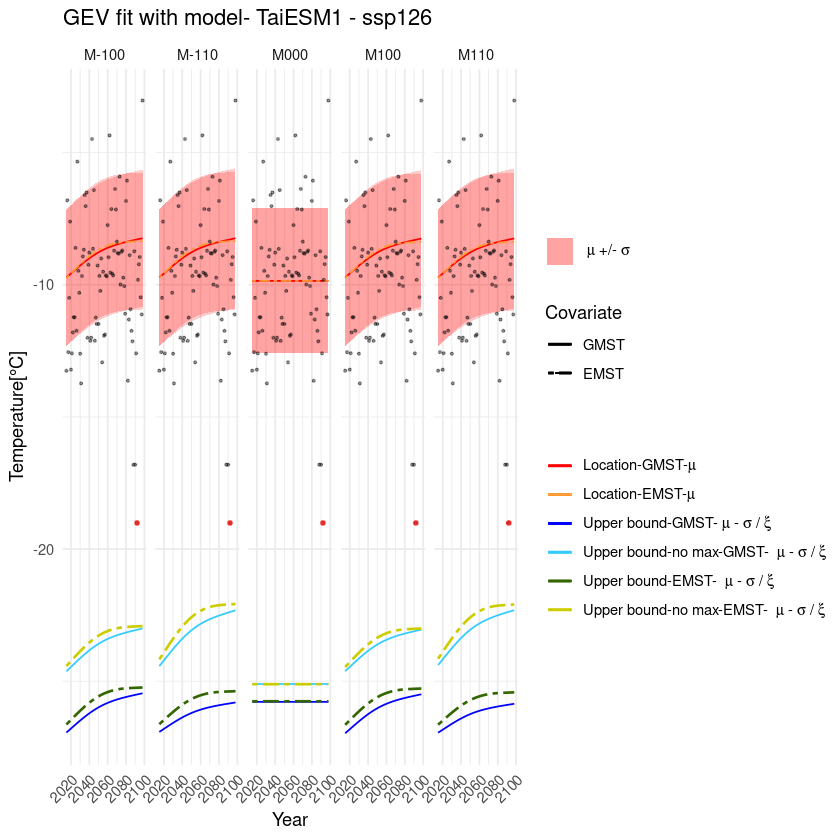

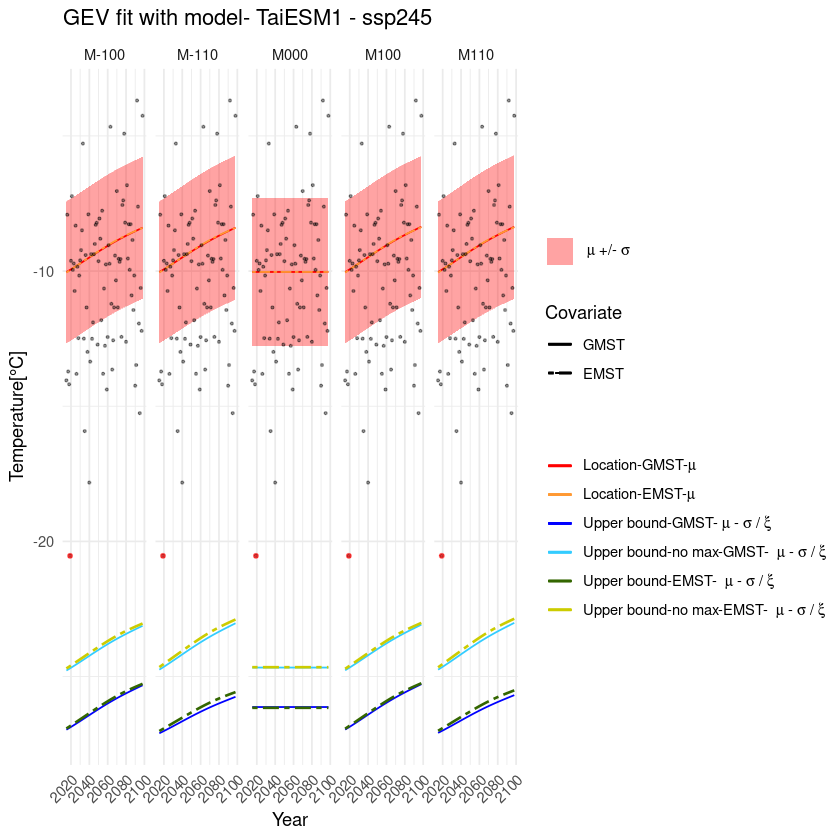

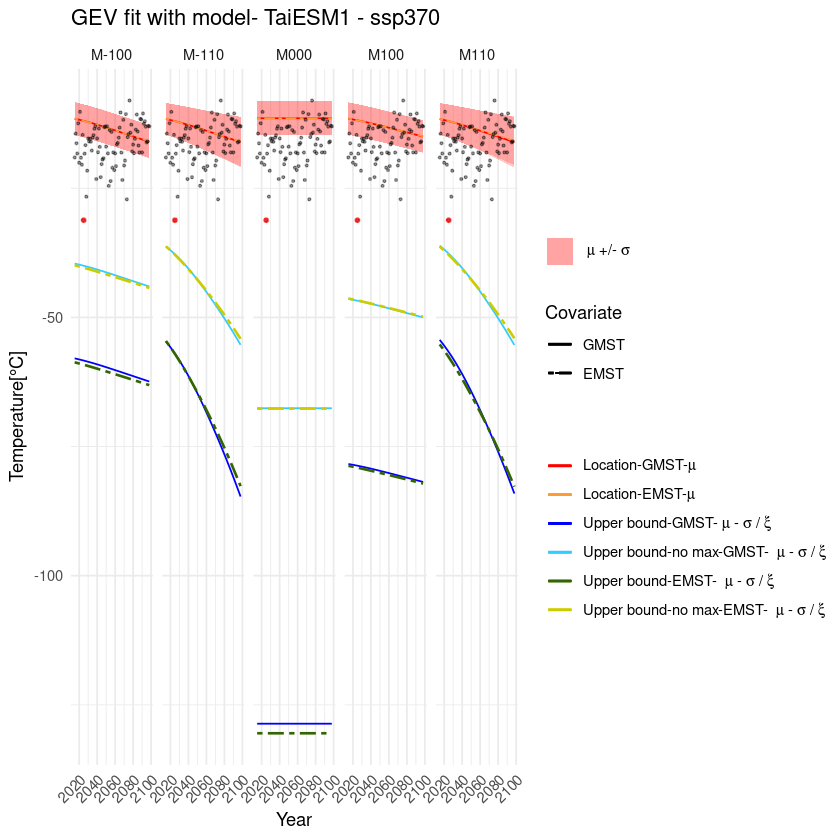

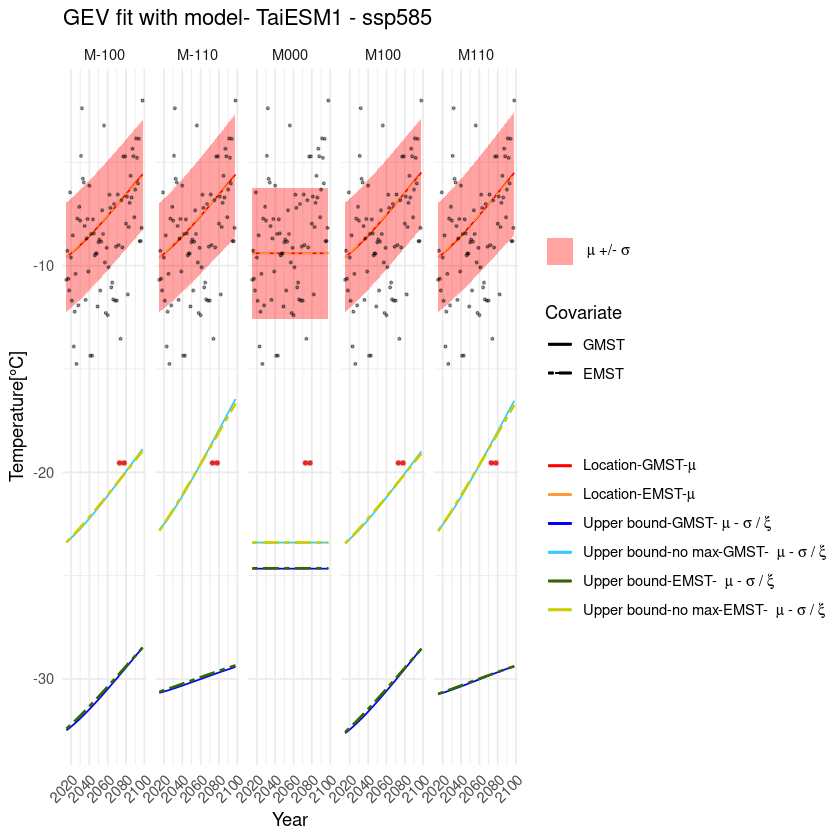

In [29]:
#```{r, TASMIN, Plot data with fit from Adjusted GEV-GMST and EMST}
ns_mod_loop = ns_models
st = c('Cirfontaines')
for(CMIP_mod in c('TaiESM1')){
  scenarios_loop = Reduce(intersect, list(v1 = unique(ns_model_GMST.tasmin.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario)), 
                                          v2 = unique(ns_model_GMST_no_max.tasmin.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario)), 
                                          v3 = unique(ns_model_EMST.tasmin.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario)), 
                                          v4 = unique(ns_model_EMST_no_max.tasmin.evol %>% filter(CMIP_model==CMIP_mod, station %in% st) %>%select(scenario))))
  for(sc in scenarios_loop[[1]]){
  ns_model_loop_GMST.evol = ns_model_GMST.tasmin.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_loop_no_max_GMST.evol = ns_model_GMST_no_max.tasmin.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_loop_EMST.evol = ns_model_EMST.tasmin.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  ns_model_loop_no_max_EMST.evol = ns_model_EMST_no_max.tasmin.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  #ns_model_loop_no_hist.evol = ns_model_GMST_no_hist.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model %in% ns_mod_loop, station %in% st)
  #ns_model_loop_2.evol = ns_model_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, ns_model==ns_mod_2)
  #print(head(ns_model_loop.evol))
  p=ggplot() +
    geom_ribbon(aes(x=year, ymin=-loc-scale, ymax=-loc+scale, fill='GEV confidence interval'),alpha=0.2, data =ns_model_loop_GMST.evol) +
    geom_line(aes(x=year, y=-loc, colour='Loc_GMST', linetype='GMST'), data=ns_model_loop_GMST.evol) +
    geom_ribbon(aes(x=year, ymin=-loc-scale, ymax=-loc+scale, fill='GEV confidence interval'),alpha=0.2, data =ns_model_loop_EMST.evol) +
    geom_line(aes(x=year, y=-loc, colour='Loc_EMST', linetype='EMST'), data=ns_model_loop_EMST.evol) +
    #geom_line(aes(x=year, y=loc, colour='Loc 2'), linetype = 'longdash', data=ns_model_loop_no_hist.evol) +
    geom_line(aes(x=year, y=-upper_bound, color='Upper bound GMST', linetype='GMST'), data=ns_model_loop_GMST.evol) +
    geom_line(aes(x=year, y=-upper_bound, color='Upper bound 2 GMST', linetype='GMST'), data=ns_model_loop_no_max_GMST.evol) +
    geom_line(aes(x=year, y=-upper_bound, color='Upper bound EMST', linetype='EMST'), size=0.75, data=ns_model_loop_EMST.evol) +
    geom_line(aes(x=year, y=-upper_bound, color='Upper bound 2 EMST', linetype='EMST'), size=0.75, data=ns_model_loop_no_max_EMST.evol) +
    #geom_line(aes(x=year, y=upper_bound, color='Upper bound 3'), data=ns_model_loop_no_hist.evol) +
    #geom_ribbon(aes(x=year, ymin=upper_bound_low, ymax=upper_bound_high, fill='Upper bound 95% confidence interval'),alpha=0.4, data =ns_model_loop.evol) +
    geom_point(aes(x=year, y=var), alpha=0.4, size=0.5, data = TN_adjust_stations_GMST %>% filter(CMIP_model==CMIP_mod, scenario%in%c(sc), station %in% st))+
    geom_point(aes(x=year, y=var), color='#FF0000', alpha=0.6, size=1, data = TN_adjust_stations_max %>% filter(CMIP_model==CMIP_mod, scenario==sc, station %in% st)) +
    theme_minimal() + 
    theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) +
    #ylim(0,80) +
    #facet_wrap(~ns_model+station, scale='free') +
    facet_grid(cols=vars(ns_model), scale='free') +
    labs(title=paste('GEV fit with model-',CMIP_mod, '-', sc), 
         x='Year',
         y='Temperature[°C]', 
         fill='', 
         colour='', 
         linetype='Covariate') +
    scale_linetype_manual(values=c('GMST'='solid', 'EMST'='twodash'))+
    scale_fill_manual(values=c('#FF0000', '#0000FF'), labels=list(bquote(~mu~"+/-"~sigma), bquote(" Upper bound")))+
    scale_color_manual(values = c('Loc_GMST'='#FF0000', 'Loc_EMST'='#ff9933', 'Upper bound GMST'='#0000FF','Upper bound 2 GMST'='#33ccff', 'Upper bound EMST'='#336600', 'Upper bound 2 EMST'='#cccc00'), labels=list(bquote("Location-GMST-"*mu), bquote("Location-EMST-"*mu), bquote("Upper bound-GMST-"~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max-GMST- "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-EMST- "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max-EMST- "~mu~ "-" ~sigma~"/"~xi)))
    #scale_color_manual(values = c('Loc_GMST'='#FF0000', 'Loc_EMST'='#ff9933', 'Upper bound GMST'='#0000FF','Upper bound 2 GMST'='#33ccff', 'Upper bound EMST'='#990099', 'Upper bound 2 EMST'='#ff66cc'), labels=list(bquote("Location-GMST-"*mu), bquote("Location-EMST-"*mu), bquote("Upper bound-GMST-"~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max-GMST- "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-EMST- "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max-EMST- "~mu~ "-" ~sigma~"/"~xi)))
  print(p)
  #ggsave(paste(fig_path,"TN_data_and_gev_GMST_and_EMST_fit_", CMIP_mod, "_", sc, "_", st, ".png", sep=""), width=8, height=5)
}
}

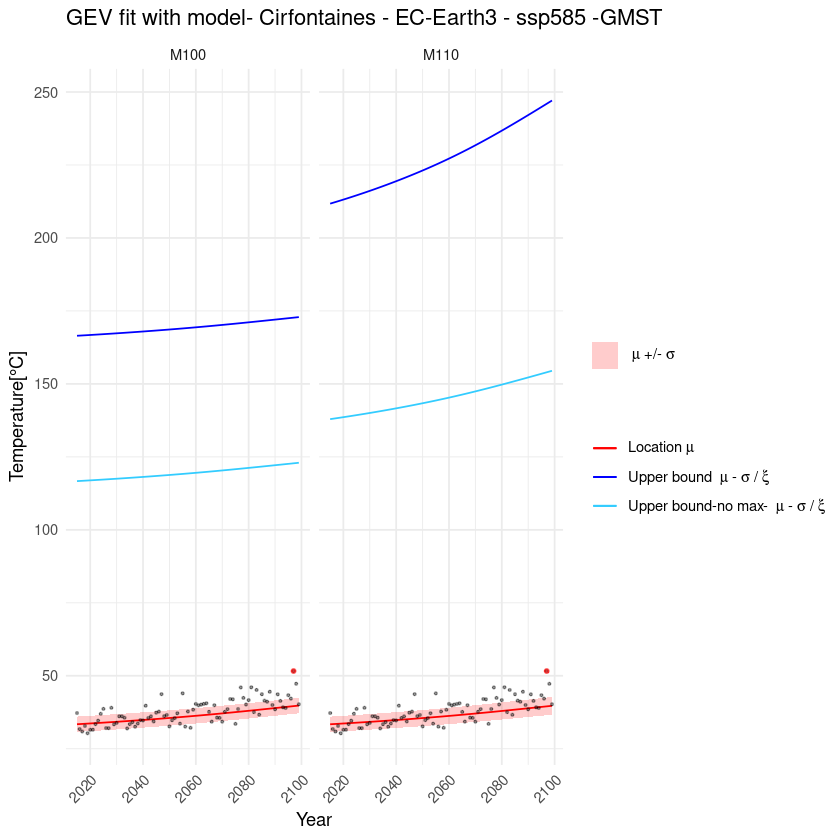

In [24]:
#```{r, Special case of fit -GMST-}
CMIP_mod = 'EC-Earth3'
sc = 'ssp585'
st = 'Cirfontaines'
ns_mod = c('M000', 'M100', 'M110')

ns_model_loop.evol = ns_model_GMST.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, station==st, ns_model %in% ns_mod)
ns_model_loop_no_max.evol = ns_model_GMST_no_max.evol %>% filter(CMIP_model==CMIP_mod, scenario==sc, station==st, ns_model %in% ns_mod)

ggplot() +
  geom_ribbon(aes(x=year, ymin=loc-scale, ymax=loc+scale, fill='GEV confidence interval'),alpha=0.2, data =ns_model_loop.evol) +
  geom_line(aes(x=year, y=loc, colour='Black'), data=ns_model_loop.evol) +
  geom_line(aes(x=year, y=upper_bound, color='Upper bound'), data=ns_model_loop.evol) +
  geom_line(aes(x=year, y=upper_bound, color='Upper bound 2'), data=ns_model_loop_no_max.evol) +
  geom_point(aes(x=year, y=var), alpha=0.4, size=0.5, data = TX_adjust_stations_GMST %>% filter(CMIP_model==CMIP_mod, scenario%in%c(sc), station==st))+
  geom_point(aes(x=year, y=var), color='#FF0000', alpha=0.6, size=1, data = TX_adjust_stations_max %>% filter(CMIP_model==CMIP_mod, scenario==sc, station==st)) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) +
  facet_grid(cols=vars(ns_model), scale='free') +
  labs(title=paste('GEV fit with model-',st,'-',CMIP_mod, '-', sc, '-GMST'), 
       x='Year',
       y='Temperature[°C]', 
       fill='', 
       colour='') +
  scale_fill_manual(values=c('#FF0000', '#0000FF'), labels=list(bquote(~mu~"+/-"~sigma), bquote(" Upper bound")))+
  scale_color_manual(values = c('#FF0000', '#0000FF', '#33ccff'), labels=list(bquote("Location "*mu), bquote("Upper bound "~mu~ "-" ~sigma~"/"~xi), bquote("Upper bound-no max- "~mu~ "-" ~sigma~"/"~xi)))
  
#ggsave(paste(fig_path,"data_and_gev_GMST_fit_", CMIP_mod, "_", sc, "_",st, ".png", sep=""), width=9, height=4)

In [25]:
#```{r, Compute observational return values}
#Yearly data
TX_adjust_stations_true_rl = data.frame(matrix(ncol = ncol(TX_adjust_stations)+1, nrow = 0))
colnames(TX_adjust_stations_true_rl) <- append(colnames(TX_adjust_stations),c('return_period'))

#Daily data
tasmax_adjust_stations_true_rl = data.frame(matrix(ncol = ncol(tasmax_adjust_stations)+1, nrow = 0))
colnames(tasmax_adjust_stations_true_rl) <- append(colnames(tasmax_adjust_stations),c('return_period'))

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in stations){
    #Yearly data 
    TX_loop = TX_adjust_stations %>% filter(scenario == sc, station == st, CMIP_model==CMIP_mod)
    n = length(unique(TX_loop$year))+1
    TX_loop$return_period[sort(TX_loop$var, index.return=TRUE, decreasing=TRUE)$ix] = n/seq(1,n+1, 1)
    TX_adjust_stations_true_rl = rbind(TX_adjust_stations_true_rl, TX_loop)
    
    #Daily data
    #print(tasmax_adjust_stations %>% filter(scenario == sc, station == st) %>% select(TX))
    data = tasmax_adjust_stations %>% filter(scenario == sc, station == st, CMIP_model==CMIP_mod)
    u = quantile(data$var, probs=0.95)
    df_loop = tasmax_adjust_stations %>% filter(scenario == sc, station == st, CMIP_model==CMIP_mod, var>u)
    df_loop$return_period[sort(df_loop$var, index.return=TRUE, decreasing=TRUE)$ix] = n/seq(1,n+1, 1)
    tasmax_adjust_stations_true_rl = rbind(tasmax_adjust_stations_true_rl, df_loop)
  }
}
}

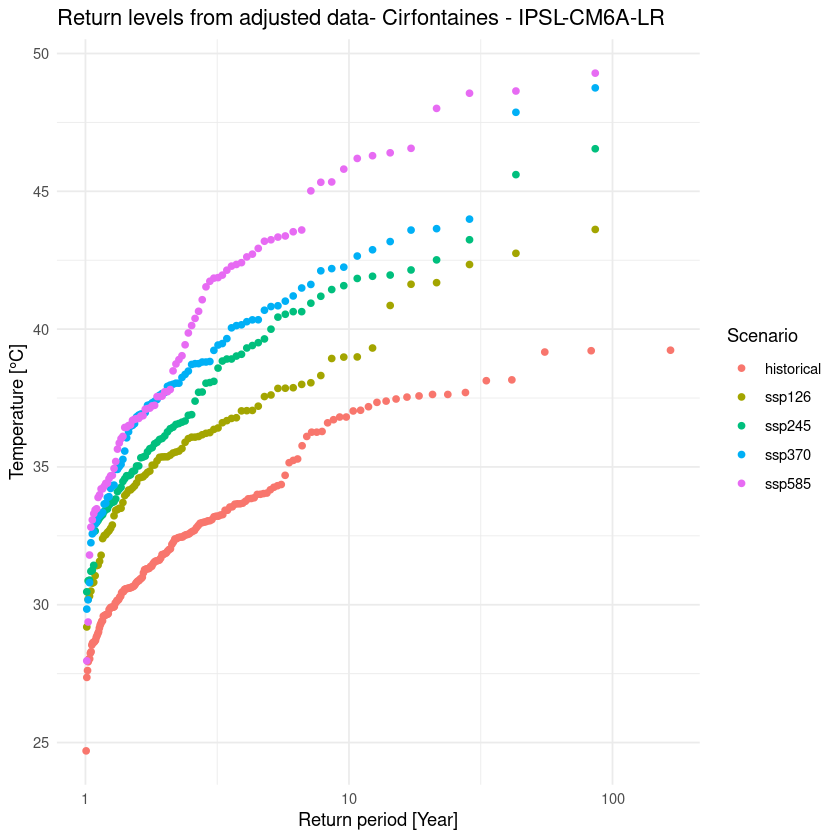

In [31]:
#```{r, Observational return level}
st = 'Cirfontaines'
CMIP_mod = 'IPSL-CM6A-LR'

TX_adjust_stations_true_rl %>%
  filter(station==st, CMIP_model==CMIP_mod) %>%
  ggplot(aes(x=return_period, y=var, color=scenario)) +
  geom_point() +
  scale_x_log10() +
  theme_minimal() +
  labs(x='Return period [Year]', 
       y='Temperature [°C]', 
       color='Scenario',
       title = paste('Return levels from adjusted data-',st, '-',CMIP_mod))

#ggsave(paste(fig_path,"return_level_obs_adjust_", CMIP_mod,"_",st, ".png", sep=""), width=6, height=3)

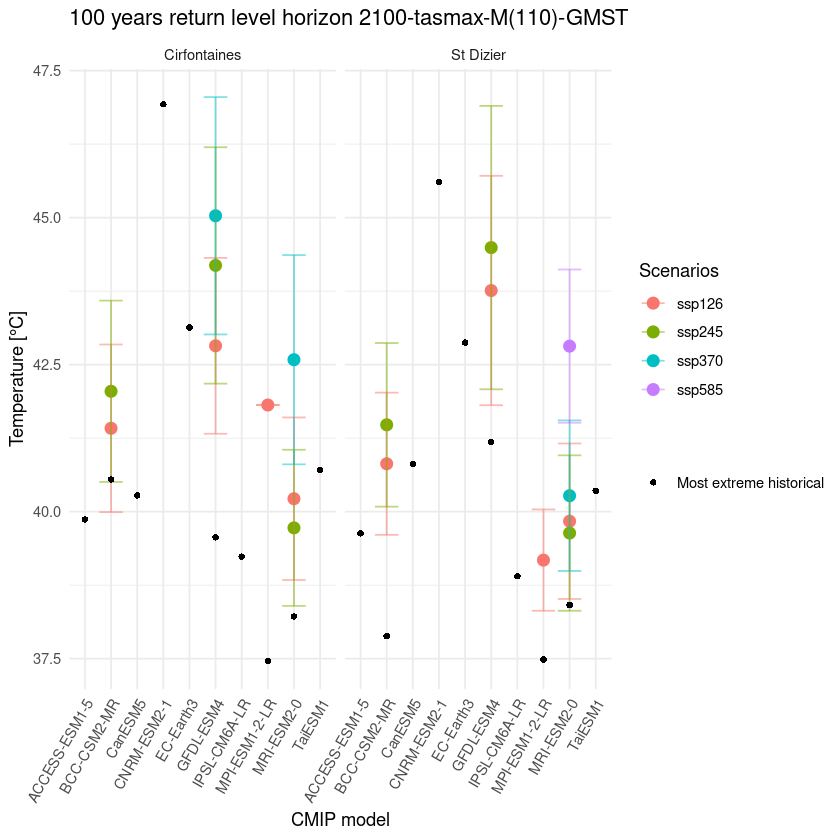

In [33]:
#```{r, Plot return levels}
stations_loop = c('Cirfontaines', 'St Dizier')
ns_mod = 'M110'
ggplot() +
  geom_point(aes(x=CMIP_model, y=return_level, color=scenario), size=3,
             data = ns_model_GMST_final.gev.rl%>%filter(ns_model==ns_mod, station %in% stations_loop)) +  
  geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color=scenario), alpha=0.5,
                data = ns_model_GMST_final.gev.rl%>%filter(ns_model==ns_mod, station %in% stations_loop))+
  #geom_point(aes(x=CMIP_model, y=return_level, color=scenario, shape='EMST'), size=3,
  #           data = ns_model_EMST_final.gev.rl%>%filter(ns_model=='M110', station=='St Dizier')) +
  #geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color=scenario, shape='EMST'), alpha=0.5,
  #              data = ns_model_EMST_final.gev.rl%>%filter(ns_model=='M110', station=='St Dizier'))+
  geom_point(aes(x=CMIP_model, y=var, shape='Most extreme historical'), color='black', 
             data = TX_adjust_stations_max %>% filter(scenario=='historical', station %in%stations_loop)) +
  scale_x_discrete(guide = guide_axis(angle=60)) +
  facet_wrap(~station)+
  #facet_grid(rows=vars(station))+
  labs(x='CMIP model', 
       y='Temperature [°C]', 
       title='100 years return level horizon 2100-tasmax-M(110)-GMST', 
       color='Scenarios', 
       shape='')+
  theme_minimal()
#ggsave(paste(fig_path,"100y_return_level_2100_tasmax_hist_most_extreme_value_GMST_M110.png", sep=""), height = 4, width = 8)

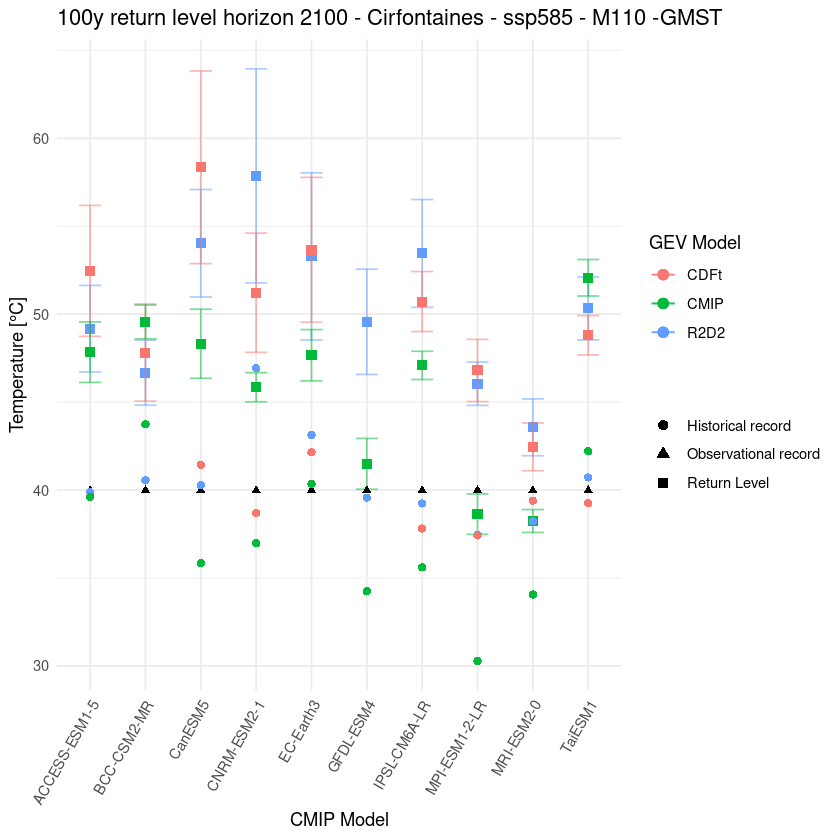

In [36]:
#```{r, TX return level CDFt and R2D2, ONE stations}
st = 'Cirfontaines'
sc = 'ssp585'
ns_mod = 'M110'

ggplot() +
  geom_point(aes(x=CMIP_model, y=return_level, shape='Return Level', color='R2D2'), size=2.5, 
             data = ns_model_GMST.gev.rl %>% filter(scenario==sc, station==st, ns_model==ns_mod)) +
  geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='R2D2'), alpha=0.5, width = 0.4, 
                data=ns_model_GMST.gev.rl %>% filter(scenario==sc, station==st, ns_model==ns_mod))+
  
  geom_point(aes(x=CMIP_model, y=return_level, shape='Return Level', color='CDFt'), size=2.5, 
             data = ns_model_CDFt_GMST.gev.rl %>% filter(scenario==sc, station==st, ns_model==ns_mod)) +
  geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='CDFt'), alpha=0.5, width = 0.4, 
                data=ns_model_CDFt_GMST.gev.rl %>% filter(scenario==sc, station==st, ns_model==ns_mod))+
  
  geom_point(aes(x=CMIP_model, y=return_level, shape='Return Level', color='CMIP'), size=2.5, 
             data = ns_model_CMIP_GMST.gev.rl %>% filter(scenario==sc, ns_model==ns_mod)) +
  geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='CMIP'), alpha=0.5, width = 0.4, 
                data=ns_model_CMIP_GMST.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  
  geom_point(aes(x=CMIP_model, y=TX, shape='Observational record'),data = TX_record_stations %>% filter(scenario==sc, station==st)) +
  geom_point(aes(x=CMIP_model, y=var, shape='Historical record', color='R2D2'), size=2, data = TX_adjust_stations_max %>% filter(scenario=='historical', station==st)) +
  geom_point(aes(x=CMIP_model, y=var, shape='Historical record', color='CDFt'), size=2, data = TX_adjust_CDFt_stations_max %>% filter(scenario=='historical', station==st)) +
  geom_point(aes(x=CMIP_model, y=var, shape='Historical record', color='CMIP'), size=2, data = TX_CMIP6_GE_max %>% filter(scenario=='historical')) +
  scale_x_discrete(guide = guide_axis(angle=60)) +
  #facet_wrap(~station) +
  #ylim(37, 65) +
  labs(x='CMIP Model', 
       y='Temperature [°C]', 
       color='GEV Model', 
       shape='', 
       title=paste('100y return level horizon 2100 -',st, '-', sc, '-', ns_mod,'-GMST')) +
  theme_minimal()
#ggsave(paste(fig_path,"tasmax_100y_return_level_GMST_CDFT_R2D2_CMIP_no_final_",ns_mod,'_',st,"_",sc,".png", sep=""), height = 6, width = 8)

In [26]:
#GMST
ns_model_GMST_diff_no_hist.gev.params =  merge(ns_model_GMST_final.gev.params, ns_model_GMST_no_hist_final.gev.params, by=c("CMIP_model", "station", "scenario", "ns_model"))
ns_model_GMST_diff_no_hist.gev.rl =  merge(ns_model_GMST_final.gev.rl, ns_model_GMST_no_hist_final.gev.rl, by=c("CMIP_model", "station", "scenario", "ns_model", "return_horizon", "return_period"))
ns_model_GMST_diff_no_hist.gev.params = merge(ns_model_GMST_diff_no_hist.gev.params, tas_global_spline %>% filter(year==2099))
ns_model_GMST_diff_no_hist.gev.all = merge(ns_model_GMST_diff_no_hist.gev.params, ns_model_GMST_diff_no_hist.gev.rl, by=c("CMIP_model", "station", "scenario", "ns_model"))
ns_model_GMST_diff_no_hist.gev.all = ns_model_GMST_diff_no_hist.gev.all %>% 
  mutate(return_level_diff = return_level.y - return_level.x, 
         r2_diff = r2.y - r2.x, 
         loc_diff = (loc_0.y + loc_1.y*var + b.y + a.y*var) - (loc_0.x + loc_1.x*var + b.x + a.x*var), 
         exp_in_scale = ifelse(ns_model%in%c('M000', 'M100', 'M-100'), 0,1) ,
         scale_diff = exp_in_scale*(exp(scale_0.y + scale_1.y*var) - exp(scale_0.x + scale_1.x*var)) +
           (1-exp_in_scale)*(scale_0.y - scale_0.x), 
         upper_bound_diff = loc_diff - 
           ((exp_in_scale*(exp(scale_0.y + scale_1.y*var)) + (1-exp_in_scale)*scale_0.y)/shape.y - 
              (exp_in_scale*(exp(scale_0.x + scale_1.x*var)) + (1-exp_in_scale)*scale_0.x)/shape.x)
         ) 

#EMST
ns_model_EMST_diff_no_hist.gev.params =  merge(ns_model_EMST_final.gev.params, ns_model_EMST_no_hist_final.gev.params, by=c("CMIP_model", "station", "scenario", "ns_model"))
ns_model_EMST_diff_no_hist.gev.rl =  merge(ns_model_EMST_final.gev.rl, ns_model_EMST_no_hist_final.gev.rl, by=c("CMIP_model", "station", "scenario", "ns_model", "return_horizon", "return_period"))
ns_model_EMST_diff_no_hist.gev.params = merge(ns_model_EMST_diff_no_hist.gev.params, tas_global_spline %>% filter(year==2099))
ns_model_EMST_diff_no_hist.gev.all = merge(ns_model_EMST_diff_no_hist.gev.params, ns_model_EMST_diff_no_hist.gev.rl, by=c("CMIP_model", "station", "scenario", "ns_model"))
ns_model_EMST_diff_no_hist.gev.all = ns_model_EMST_diff_no_hist.gev.all %>% 
  mutate(return_level_diff = return_level.y - return_level.x, 
         r2_diff = r2.y - r2.x, 
         loc_diff = (loc_0.y + loc_1.y*var + b.y + a.y*var) - (loc_0.x + loc_1.x*var + b.x + a.x*var), 
         exp_in_scale = ifelse(ns_model%in%c('M000', 'M100', 'M-100'), 0,1) ,
         scale_diff = exp_in_scale*(exp(scale_0.y + scale_1.y*var) - exp(scale_0.x + scale_1.x*var)) +
           (1-exp_in_scale)*(scale_0.y - scale_0.x), 
         upper_bound_diff = loc_diff - 
           ((exp_in_scale*(exp(scale_0.y + scale_1.y*var)) + (1-exp_in_scale)*scale_0.y)/shape.y - 
              (exp_in_scale*(exp(scale_0.x + scale_1.x*var)) + (1-exp_in_scale)*scale_0.x)/shape.x)
         ) 

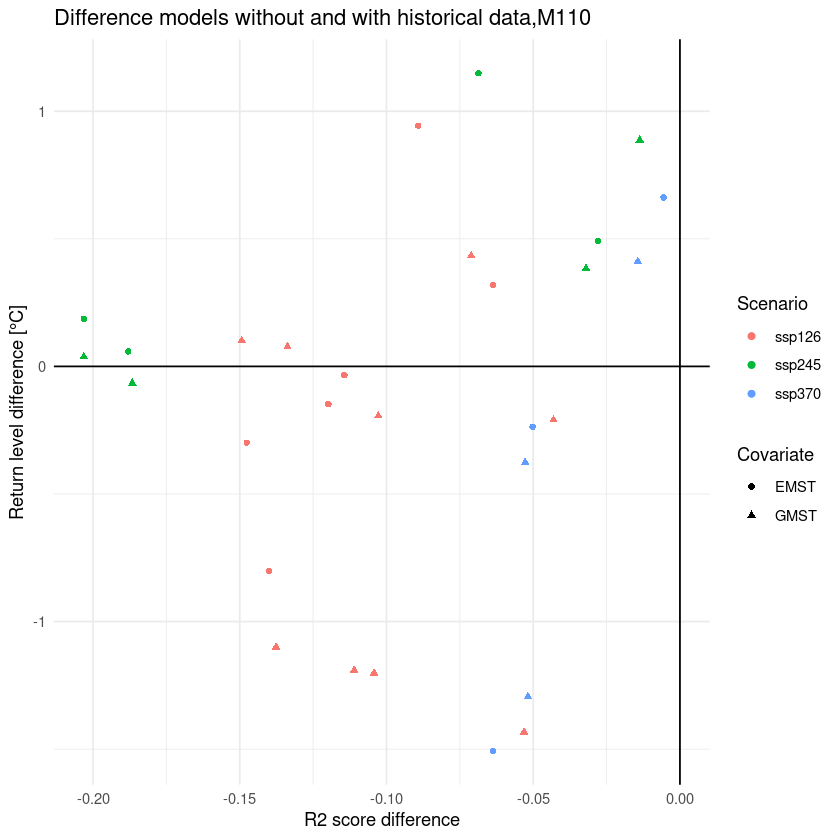

In [38]:
ggplot() +
  geom_point(aes(x=r2_diff, y=return_level_diff, color=scenario, shape='GMST'), 
             data = ns_model_GMST_diff_no_hist.gev.all%>%filter(ns_model=='M110')) + 
  geom_point(aes(x=r2_diff, y=return_level_diff, color=scenario, shape='EMST'), 
             data = ns_model_EMST_diff_no_hist.gev.all%>%filter(ns_model=='M110')) + 
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +

  #geom_point(aes(x=ns_model_GMST_no_hist.gev.params$r2, y=ns_model_GMST_no_hist.gev.rl$return_level, color='No', ns_mod='M110')) + 
  labs(x='R2 score difference', 
       y='Return level difference [°C]', 
       color='Scenario',
       shape='Covariate',
       title='Difference models without and with historical data,M110')+
  #facet_wrap(~scenario) +
  theme_minimal()
#ggsave(paste(fig_path,"100y_return_level_2100_diff_no_hist_original.png", sep=""), width=7, height=4)

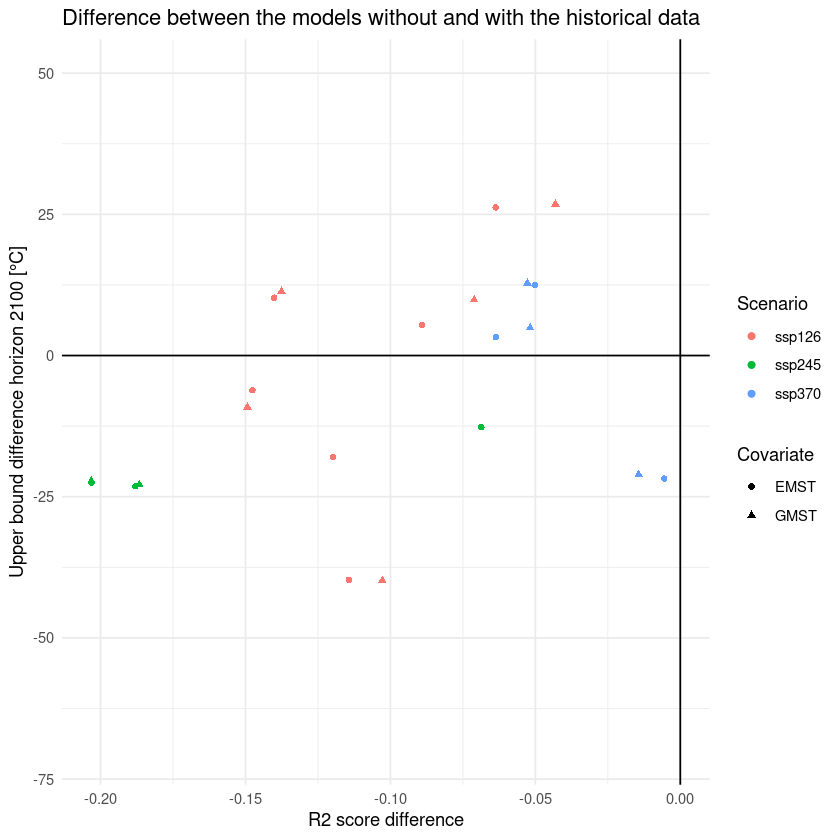

In [39]:
ggplot() +
  geom_point(aes(x=r2_diff, y=upper_bound_diff, color=scenario, shape='GMST'), 
             data = ns_model_GMST_diff_no_hist.gev.all%>%filter(ns_model=='M110')) + 
  geom_point(aes(x=r2_diff, y=upper_bound_diff, color=scenario, shape='EMST'), 
             data = ns_model_EMST_diff_no_hist.gev.all%>%filter(ns_model=='M110')) + 
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +

  #geom_point(aes(x=ns_model_GMST_no_hist.gev.params$r2, y=ns_model_GMST_no_hist.gev.rl$return_level, color='No', ns_mod='M110')) + 
  labs(x='R2 score difference', 
       y='Upper bound difference horizon 2100 [°C]', 
       color='Scenario',
       shape='Covariate',
       title='Difference between the models without and with the historical data')+
  ylim(-70,50)+
  #facet_wrap(~scenario) +
  theme_minimal()
#ggsave(paste(fig_path,"upper_bound_2100_diff_no_hist_original.png", sep=""), width=6, height=4)

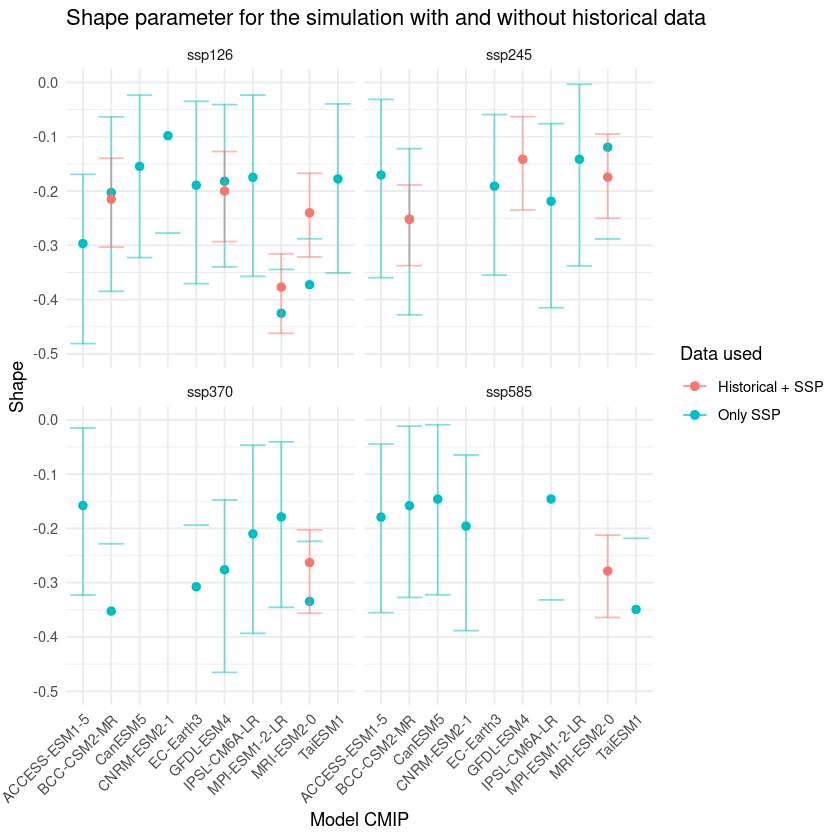

In [40]:
st='St Dizier'
ggplot()+
  geom_point(aes(x=CMIP_model, y=shape, color='Only SSP'), size=2,
             data = ns_model_GMST_no_hist_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_errorbar(aes(x=CMIP_model, ymin=shape_low, ymax=shape_high, color='Only SSP'), alpha=0.5,
             data = ns_model_GMST_no_hist_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_point(aes(x=CMIP_model, y=shape, color='Historical + SSP'), size=2,
             data = ns_model_GMST_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_errorbar(aes(x=CMIP_model, ymin=shape_low, ymax=shape_high, color='Historical + SSP'), alpha=0.5,
             data = ns_model_GMST_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  ylim(-0.5, 0)+
  scale_x_discrete(guide = guide_axis(angle=45)) +
  facet_wrap(~scenario) +
  labs(x='Model CMIP', y='Shape', 
       color='Data used', 
       title = 'Shape parameter for the simulation with and without historical data') +
  theme_minimal()

#ggsave(paste(fig_path,"tasmax_shape_no_hist_original_",st,".png", sep=""), width=8, height=5)

In [27]:
tasmax_adjust_stations_no_max = data.frame(tasmax_adjust_stations)
tasmax_adjust_stations_max = data.frame(matrix(ncol = ncol(tasmax_adjust_stations_no_max), nrow = 0))
colnames(tasmax_adjust_stations_max) = colnames(tasmax_adjust_stations_no_max)
tasmax_adjust_stations_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmax_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

#tasmax_adjust_stations_no_max.JJA = data.frame(tasmax_adjust_stations.JJA)
#tasmax_adjust_stations_max.JJA = data.frame(matrix(ncol = ncol(tasmax_adjust_stations_no_max.JJA), nrow = 0))
#colnames(tasmax_adjust_stations_max.JJA) = colnames(tasmax_adjust_stations_no_max.JJA)

TX_adjust_stations_no_max = data.frame(TX_adjust_stations)
TX_adjust_stations_max = data.frame(matrix(ncol = ncol(TX_adjust_stations_no_max), nrow = 0))
colnames(TX_adjust_stations_max) = colnames(TX_adjust_stations_no_max)
TX_adjust_stations_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TX_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in stations){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmax_adjust_stations_no_max$var == max(tasmax_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmax_adjust_stations_no_max$CMIP_model == CMIP_mod & tasmax_adjust_stations_no_max$station ==st & tasmax_adjust_stations_no_max$scenario==sc)
    tasmax_adjust_stations_max = rbind(tasmax_adjust_stations_max, tasmax_adjust_stations_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmax_adjust_stations_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmax_adjust_stations_no_max$station == st & 
                               tasmax_adjust_stations_no_max$scenario == sc &
                               tasmax_adjust_stations_no_max$CMIP_model == CMIP_mod &
                               tasmax_adjust_stations_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmax_adjust_stations_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TX_max_loop = which(TX_adjust_stations_no_max$var == max(TX_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TX_adjust_stations_no_max$CMIP_model == CMIP_mod & TX_adjust_stations_no_max$station ==st & TX_adjust_stations_no_max$scenario==sc)
    TX_adjust_stations_max = rbind(TX_adjust_stations_max, TX_adjust_stations_no_max[c(TX_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TX_adjust_stations_no_max[c(TX_max_loop), 'var'] = NaN
    
    diff_loop = max(TX_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TX_adjust_stations_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TX_adjust_stations_diff_max = rbind(TX_adjust_stations_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

In [28]:
tasmax_adjust_CDFt_stations_no_max = data.frame(tasmax_adjust_CDFt_stations)
tasmax_adjust_CDFt_stations_max = data.frame(matrix(ncol = ncol(tasmax_adjust_CDFt_stations_no_max), nrow = 0))
colnames(tasmax_adjust_CDFt_stations_max) = colnames(tasmax_adjust_CDFt_stations_no_max)
tasmax_adjust_CDFt_stations_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmax_adjust_CDFt_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

#tasmax_adjust_stations_no_max.JJA = data.frame(tasmax_adjust_stations.JJA)
#tasmax_adjust_stations_max.JJA = data.frame(matrix(ncol = ncol(tasmax_adjust_stations_no_max.JJA), nrow = 0))
#colnames(tasmax_adjust_stations_max.JJA) = colnames(tasmax_adjust_stations_no_max.JJA)

TX_adjust_CDFt_stations_no_max = data.frame(TX_adjust_CDFt_stations)
TX_adjust_CDFt_stations_max = data.frame(matrix(ncol = ncol(TX_adjust_CDFt_stations_no_max), nrow = 0))
colnames(TX_adjust_CDFt_stations_max) = colnames(TX_adjust_CDFt_stations_no_max)
TX_adjust_CDFt_stations_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TX_adjust_CDFt_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models_no_GFDL){
  for(sc in scenarios){
  for(st in stations){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmax_adjust_CDFt_stations_no_max$var == max(tasmax_adjust_CDFt_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmax_adjust_CDFt_stations_no_max$CMIP_model == CMIP_mod & tasmax_adjust_CDFt_stations_no_max$station ==st & tasmax_adjust_CDFt_stations_no_max$scenario==sc)
    tasmax_adjust_CDFt_stations_max = rbind(tasmax_adjust_CDFt_stations_max, tasmax_adjust_CDFt_stations_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmax_adjust_CDFt_stations_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmax_adjust_CDFt_stations_no_max$station == st & 
                               tasmax_adjust_CDFt_stations_no_max$scenario == sc &
                               tasmax_adjust_CDFt_stations_no_max$CMIP_model == CMIP_mod &
                               tasmax_adjust_CDFt_stations_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmax_adjust_CDFt_stations_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TX_max_loop = which(TX_adjust_CDFt_stations_no_max$var == max(TX_adjust_CDFt_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TX_adjust_CDFt_stations_no_max$CMIP_model == CMIP_mod & TX_adjust_CDFt_stations_no_max$station ==st & TX_adjust_CDFt_stations_no_max$scenario==sc)
    TX_adjust_CDFt_stations_max = rbind(TX_adjust_CDFt_stations_max, TX_adjust_CDFt_stations_no_max[c(TX_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TX_adjust_CDFt_stations_no_max[c(TX_max_loop), 'var'] = NaN
    
    diff_loop = max(TX_adjust_CDFt_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TX_adjust_CDFt_stations_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TX_adjust_CDFt_stations_diff_max = rbind(TX_adjust_CDFt_stations_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

In [29]:
#```{r, compute dataframes without yearly and daily maximum, CMIP}
tasmax_CMIP6_GE_no_max = data.frame(tasmax_CMIP6_GE)
tasmax_CMIP6_GE_max = data.frame(matrix(ncol = ncol(tasmax_CMIP6_GE_no_max), nrow = 0))
colnames(tasmax_CMIP6_GE_max) = colnames(tasmax_CMIP6_GE_no_max)
tasmax_CMIP6_GE_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmax_CMIP6_GE_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

TX_CMIP6_GE_no_max = data.frame(TX_CMIP6_GE)
TX_CMIP6_GE_max = data.frame(matrix(ncol = ncol(TX_CMIP6_GE_no_max), nrow = 0))
colnames(TX_CMIP6_GE_max) = colnames(TX_CMIP6_GE_no_max)
TX_CMIP6_GE_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TX_CMIP6_GE_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in c('GrandEst')){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmax_CMIP6_GE_no_max$var == max(tasmax_CMIP6_GE %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmax_CMIP6_GE_no_max$CMIP_model == CMIP_mod & tasmax_CMIP6_GE_no_max$station ==st & tasmax_CMIP6_GE_no_max$scenario==sc)
    tasmax_CMIP6_GE_max = rbind(tasmax_CMIP6_GE_max, tasmax_CMIP6_GE_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmax_CMIP6_GE_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmax_CMIP6_GE_no_max$station == st & 
                               tasmax_CMIP6_GE_no_max$scenario == sc &
                               tasmax_CMIP6_GE_no_max$CMIP_model == CMIP_mod &
                               tasmax_CMIP6_GE_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmax_CMIP6_GE_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TX_max_loop = which(TX_CMIP6_GE_no_max$var == max(TX_CMIP6_GE %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TX_CMIP6_GE_no_max$CMIP_model == CMIP_mod & TX_CMIP6_GE_no_max$station ==st & TX_CMIP6_GE_no_max$scenario==sc)
    TX_CMIP6_GE_max = rbind(TX_CMIP6_GE_max, TX_CMIP6_GE_no_max[c(TX_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TX_CMIP6_GE_no_max[c(TX_max_loop), 'var'] = NaN
    
    diff_loop = max(TX_CMIP6_GE %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TX_CMIP6_GE_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TX_CMIP6_GE_diff_max = rbind(TX_CMIP6_GE_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

In [30]:
#```{r, TASMIN, compute dataframes without yearly and daily maximum}
tasmin_adjust_stations_no_max = data.frame(tasmin_adjust_stations)
tasmin_adjust_stations_max = data.frame(matrix(ncol = ncol(tasmin_adjust_stations_no_max), nrow = 0))
colnames(tasmin_adjust_stations_max) = colnames(tasmin_adjust_stations_no_max)
tasmin_adjust_stations_diff_max = data.frame(matrix(ncol=4, nrow = 0))
colnames(tasmin_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

TN_adjust_stations_no_max = data.frame(TN_adjust_stations)
TN_adjust_stations_max = data.frame(matrix(ncol = ncol(TN_adjust_stations_no_max), nrow = 0))
colnames(TN_adjust_stations_max) = colnames(TN_adjust_stations_no_max)
TN_adjust_stations_diff_max = data.frame(matrix(ncol = 4, nrow = 0))
colnames(TN_adjust_stations_diff_max) = c('CMIP_model', 'scenario', 'station', 'var')

for(CMIP_mod in models){
  for(sc in scenarios){
  for(st in stations){
    #Remove all the year corresponding to the daily maximum
    df_max_loop = which(tasmin_adjust_stations_no_max$var == min(tasmin_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var))  & tasmin_adjust_stations_no_max$CMIP_model == CMIP_mod & tasmin_adjust_stations_no_max$station ==st & tasmin_adjust_stations_no_max$scenario==sc)
    tasmin_adjust_stations_max = rbind(tasmin_adjust_stations_max, tasmin_adjust_stations_no_max[c(df_max_loop), ])
    
    year_max_loop = tasmin_adjust_stations_no_max[df_max_loop,]$year
    df_year_max_loop = which(tasmin_adjust_stations_no_max$station == st & 
                               tasmin_adjust_stations_no_max$scenario == sc &
                               tasmin_adjust_stations_no_max$CMIP_model == CMIP_mod &
                               tasmin_adjust_stations_no_max$year == year_max_loop)
    #tasmax_adjust_stations_no_max = tasmax_adjust_stations_no_max[-c(df_year_max_loop),]
    tasmin_adjust_stations_no_max[c(df_year_max_loop),'var']=NaN
    
    #Remove yearly maximum
    TN_max_loop = which(TN_adjust_stations_no_max$var == min(TN_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) & TN_adjust_stations_no_max$CMIP_model == CMIP_mod & TN_adjust_stations_no_max$station ==st & TN_adjust_stations_no_max$scenario==sc)
    TN_adjust_stations_max = rbind(TN_adjust_stations_max, TN_adjust_stations_no_max[c(TN_max_loop), ])
    #TX_adjust_stations_no_max = TX_adjust_stations_no_max[-c(TX_max_loop), ]
    TN_adjust_stations_no_max[c(TN_max_loop), 'var'] = NaN
    
    diff_loop = max(TN_adjust_stations %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var)) -
      max(TN_adjust_stations_no_max %>% filter(station==st, scenario==sc, CMIP_model==CMIP_mod) %>% select(var), na.rm = TRUE)
    TN_adjust_stations_diff_max = rbind(TN_adjust_stations_diff_max, data.frame(CMIP_model=CMIP_mod, 
                                                                                scenario=sc, 
                                                                                station=st, 
                                                                                var = diff_loop))
  }
}
}

In [32]:
TX_adjust_stations_no_max_GMST = merge(TX_adjust_stations_no_max, tas_global_spline_mutate, by=c("year", "scenario", "CMIP_model"))
TX_adjust_stations_no_max_EMST = merge(TX_adjust_stations_no_max, tas_europe_spline_mutate, by=c("year", "scenario", "CMIP_model"))

In [34]:
#### Parameters absolute difference ####
ns_model_GMST_diff_no_max.gev.params =  merge(ns_model_GMST_final.gev.params, ns_model_GMST_no_max_final.gev.params, by=c("CMIP_model", "station", "scenario", "ns_model"))
ns_model_GMST_diff_no_max.gev.params = merge(ns_model_GMST_diff_no_max.gev.params, tas_global_spline %>% filter(year==2099))
ns_model_GMST_diff_no_max.gev.params = na.omit(ns_model_GMST_diff_no_max.gev.params)
#ns_model_GMST_diff_no_max.gev.params %>% filter(CMIP_model=='ACCESS-ESM1-5', station=='Bure', scenario=='ssp126')
#head(ns_model_GMST_diff_no_max.gev.params %>% mutate(test = (loc_0.y + loc_1.y*covariate + b.y + a.y*covariate) - (loc_0.x + loc_1.x*covariate + b.x + a.x*covariate)))


ns_model_GMST_diff_no_max.gev.params = ns_model_GMST_diff_no_max.gev.params %>%
  mutate(loc_diff = (loc_0.y + loc_1.y*covariate + b.y + a.y*covariate) - (loc_0.x + loc_1.x*covariate + b.x + a.x*covariate), 
         loc_diff_low = (loc_0_low.y + loc_1_low.y*covariate + (b.y-b_std.y) + (a.y-a_std.y)*covariate) - (loc_0_high.x + loc_1_high.x*var + (b.x+b_std.x) + (a.x+a_std.x)*var), 
         loc_diff_high = (loc_0_high.y + loc_1_high.y*covariate + (b.y+b_std.y) + (a.y+a_std.y)*var) - (loc_0_low.x + loc_1_low.x*var + (b.x-b_std.x) + (a.x-a_std.x)*var), 
         exp_in_scale = ifelse(ns_model%in%c('M000', 'M100', 'M-100'), 0,1) ,
         scale_diff = exp_in_scale*(exp(scale_0.y + scale_1.y*var) - exp(scale_0.x + scale_1.x*var)) +
           (1-exp_in_scale)*(scale_0.y - scale_0.x), 
         #scale_diff_low = exp(scale_0_low.y + scale_1_low.y*var) - exp(scale_0_high.x + scale_1_high.x*var), 
         #scale_diff_high = exp(scale_0_high.y + scale_1_high.y*var) - exp(scale_0_low.x + scale_1_low.x*var), 
         shape_diff = shape.y - shape.x, 
         shape_low = shape_low.y - shape_high.x, 
         shape_high = shape_high.y - shape_low.x, 
         upper_bound_diff = loc_diff - 
           ((exp_in_scale*(exp(scale_0.y + scale_1.y*var)) + (1-exp_in_scale)*scale_0.y)/shape.y - 
              (exp_in_scale*(exp(scale_0.x + scale_1.x*var)) + (1-exp_in_scale)*scale_0.x)/shape.x)
         ) %>%
  select(-c(loc_0.x, loc_0_low.x, loc_0_high.x, loc_1.x, loc_1_low.x, loc_1_high.x, loc_0.y, loc_0_low.y, loc_0_high.y, loc_1.y, loc_1_low.y, loc_1_high.y, scale_0.x, scale_0_low.x, scale_0_high.x, scale_1.x, scale_1_low.x, scale_1_high.x, scale_0.y, scale_0_low.y, scale_0_high.y, scale_1.y, scale_1_low.y, scale_1_high.y, shape.x, shape.y, shape_low.x, shape_low.y, shape_high.x, shape_high.y, var, a.x, a_std.x, b.x, b_std.x, a.y, a_std.y, b.y, b_std.y, nllh.x, nllh.y))

ns_model_GMST_diff_no_max.gev.params = merge(ns_model_GMST_diff_no_max.gev.params, TX_adjust_stations_diff_max, by=c("CMIP_model", "station", "scenario"))

#### Return levels absolute difference ####
ns_model_GMST_diff_no_max.gev.rl =  merge(ns_model_GMST_final.gev.rl, ns_model_GMST_no_max_final.gev.rl, by=c("CMIP_model", "station", "scenario", "ns_model", "return_horizon", "return_period"))
ns_model_GMST_diff_no_max.gev.rl = na.omit(ns_model_GMST_diff_no_max.gev.rl)
ns_model_GMST_diff_no_max.gev.rl = ns_model_GMST_diff_no_max.gev.rl %>% 
  mutate(return_level_diff = return_level.y - return_level.x, 
         return_level_diff_low = return_level_low.y - return_level_high.x, 
         return_level_diff_high = return_level_high.y - return_level_low.x) %>%
  select(-c(return_level.x, return_level.y, return_level_low.x, return_level_low.y, return_level_high.x, return_level_high.y))

ns_model_GMST_diff_no_max.gev.rl = merge(ns_model_GMST_diff_no_max.gev.rl, TX_adjust_stations_diff_max, by=c("CMIP_model", "station", "scenario"))

####EMST####
ns_model_EMST_diff_no_max.gev.params =  merge(ns_model_EMST_final.gev.params, ns_model_EMST_no_max_final.gev.params, by=c("CMIP_model", "station", "scenario", "ns_model"))
ns_model_EMST_diff_no_max.gev.params = merge(ns_model_EMST_diff_no_max.gev.params, tas_global_spline %>% filter(year==2099))
ns_model_EMST_diff_no_max.gev.params = na.omit(ns_model_EMST_diff_no_max.gev.params)

ns_model_EMST_diff_no_max.gev.params = ns_model_EMST_diff_no_max.gev.params %>%
  mutate(loc_diff = (loc_0.y + loc_1.y*var + b.y + a.y*var) - (loc_0.x + loc_1.x*var + b.x + a.x*var), 
         loc_diff_low = (loc_0_low.y + loc_1_low.y*var + (b.y-b_std.y) + (a.y-a_std.y)*var) - (loc_0_high.x + loc_1_high.x*var + (b.x+b_std.x) + (a.x+a_std.x)*var), 
         loc_diff_high = (loc_0_high.y + loc_1_high.y*var + (b.y+b_std.y) + (a.y+a_std.y)*var) - (loc_0_low.x + loc_1_low.x*var + (b.x-b_std.x) + (a.x-a_std.x)*var), 
         exp_in_scale = ifelse(ns_model%in%c('M000', 'M100', 'M-100'), 0,1) ,
         scale_diff = exp_in_scale*(exp(scale_0.y + scale_1.y*var) - exp(scale_0.x + scale_1.x*var)) +
           (1-exp_in_scale)*(scale_0.y - scale_0.x), 
         #scale_diff_low = exp(scale_0_low.y + scale_1_low.y*var) - exp(scale_0_high.x + scale_1_high.x*var), 
         #scale_diff_high = exp(scale_0_high.y + scale_1_high.y*var) - exp(scale_0_low.x + scale_1_low.x*var), 
         shape_diff = shape.y - shape.x, 
         shape_low = shape_low.y - shape_high.x, 
         shape_high = shape_high.y - shape_low.x, 
         upper_bound_diff = loc_diff - 
           ((exp_in_scale*(exp(scale_0.y + scale_1.y*var)) + (1-exp_in_scale)*scale_0.y)/shape.y - 
              (exp_in_scale*(exp(scale_0.x + scale_1.x*var)) + (1-exp_in_scale)*scale_0.x)/shape.x)
         ) %>%
  select(-c(loc_0.x, loc_0_low.x, loc_0_high.x, loc_1.x, loc_1_low.x, loc_1_high.x, loc_0.y, loc_0_low.y, loc_0_high.y, loc_1.y, loc_1_low.y, loc_1_high.y, scale_0.x, scale_0_low.x, scale_0_high.x, scale_1.x, scale_1_low.x, scale_1_high.x, scale_0.y, scale_0_low.y, scale_0_high.y, scale_1.y, scale_1_low.y, scale_1_high.y, shape.x, shape.y, shape_low.x, shape_low.y, shape_high.x, shape_high.y, var, a.x, a_std.x, b.x, b_std.x, a.y, a_std.y, b.y, b_std.y, nllh.x, nllh.y))

ns_model_EMST_diff_no_max.gev.params = merge(ns_model_EMST_diff_no_max.gev.params, TX_adjust_stations_diff_max, by=c("CMIP_model", "station", "scenario"))

#### Return levels absolute difference ####
ns_model_EMST_diff_no_max.gev.rl =  merge(ns_model_EMST_final.gev.rl, ns_model_EMST_no_max_final.gev.rl, by=c("CMIP_model", "station", "scenario", "ns_model", "return_horizon", "return_period"))
ns_model_EMST_diff_no_max.gev.rl = ns_model_EMST_diff_no_max.gev.rl %>% 
  mutate(return_level_diff = return_level.y - return_level.x, 
         return_level_diff_low = return_level_low.y - return_level_high.x, 
         return_level_diff_high = return_level_high.y - return_level_low.x) %>%
  select(-c(return_level.x, return_level.y, return_level_low.x, return_level_low.y, return_level_high.x, return_level_high.y))

ns_model_EMST_diff_no_max.gev.rl = merge(ns_model_EMST_diff_no_max.gev.rl, TX_adjust_stations_diff_max, by=c("CMIP_model", "station", "scenario"))

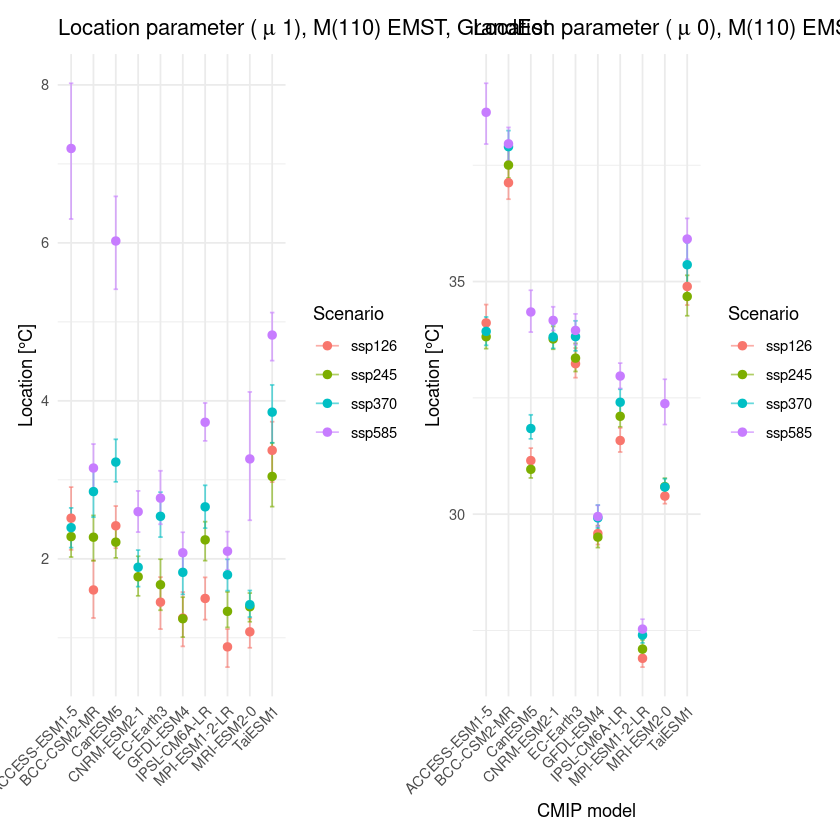

In [39]:
st='GrandEst'
P1 =ggplot()+
  geom_errorbar(aes(x=CMIP_model, ymin=loc_1_low, ymax=loc_1_high, color=scenario), alpha=0.6, width=0.2,
             data = ns_model_CMIP_EMST.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_point(aes(x=CMIP_model, y=loc_1, color=scenario), size=2,
             data = ns_model_CMIP_EMST.gev.params%>%filter(ns_model=='M110', station==st)) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(x="", y='Location [°C]', 
       color='Scenario', 
       title = bquote("Location parameter ("~mu~ "1), M(110) EMST, GrandEst")) +
  theme_minimal()

P2 =ggplot()+
  geom_errorbar(aes(x=CMIP_model, ymin=loc_0_low, ymax=loc_0_high, color=scenario), alpha=0.6, width=0.2,
             data = ns_model_CMIP_EMST.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_point(aes(x=CMIP_model, y=loc_0, color=scenario), size=2,
             data = ns_model_CMIP_EMST.gev.params%>%filter(ns_model=='M110', station==st)) +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  labs(x="CMIP model", y='Location [°C]', 
       color='Scenario', 
       title = bquote("Location parameter ("~mu~ "0), M(110) EMST, GrandEst")) +
  theme_minimal()

P1+P2
#plot_grid(P1, P2, nrow=2)
#ggsave(paste(fig_path,"tasmax_CMIP_location_1_and_0_EMST_M110_",st,".png", sep=""), width=8, height=6)

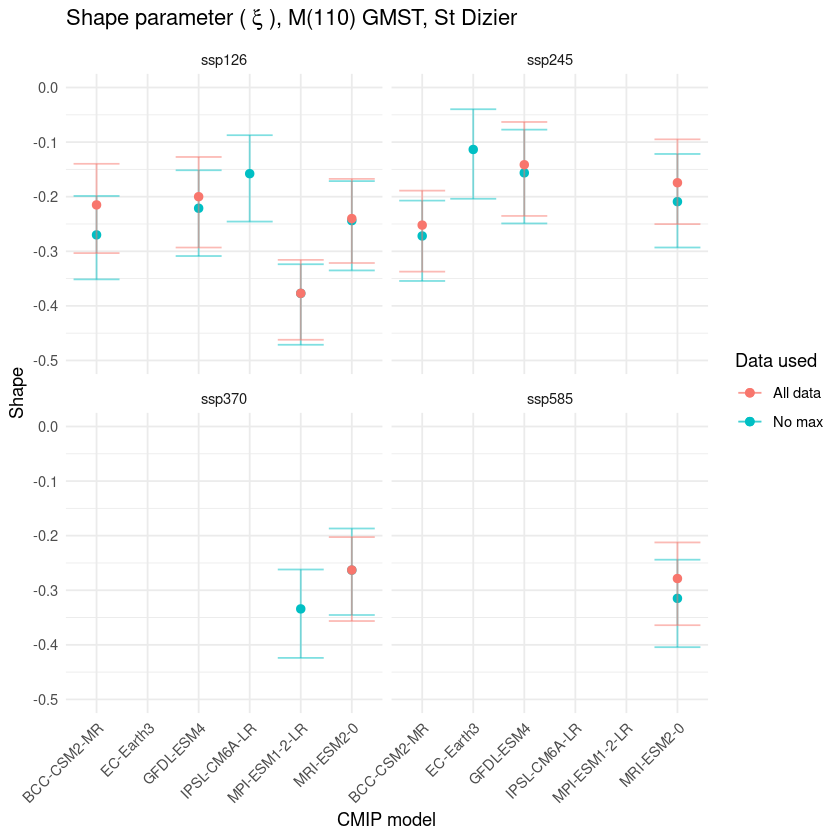

In [40]:
st='St Dizier'
ggplot()+
  geom_point(aes(x=CMIP_model, y=shape, color='No max'), size=2,
             data = ns_model_GMST_no_max_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_errorbar(aes(x=CMIP_model, ymin=shape_low, ymax=shape_high, color='No max'), alpha=0.5,
             data = ns_model_GMST_no_max_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_point(aes(x=CMIP_model, y=shape, color='All data'), size=2,
             data = ns_model_GMST_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  geom_errorbar(aes(x=CMIP_model, ymin=shape_low, ymax=shape_high, color='All data'), alpha=0.5,
             data = ns_model_GMST_final.gev.params%>%filter(ns_model=='M110', station==st)) +
  ylim(-0.5, 0)+
  scale_x_discrete(guide = guide_axis(angle=45)) +
  facet_wrap(~scenario) +
  labs(x="CMIP model", y='Shape', 
       color='Data used', 
       title = bquote("Shape parameter ("~xi~ "), M(110) GMST, St Dizier")) +
  theme_minimal()

#ggsave(paste(fig_path,"tasmax_shape_no_max_original_GMST_M110_",st,".png", sep=""), width=8, height=5)

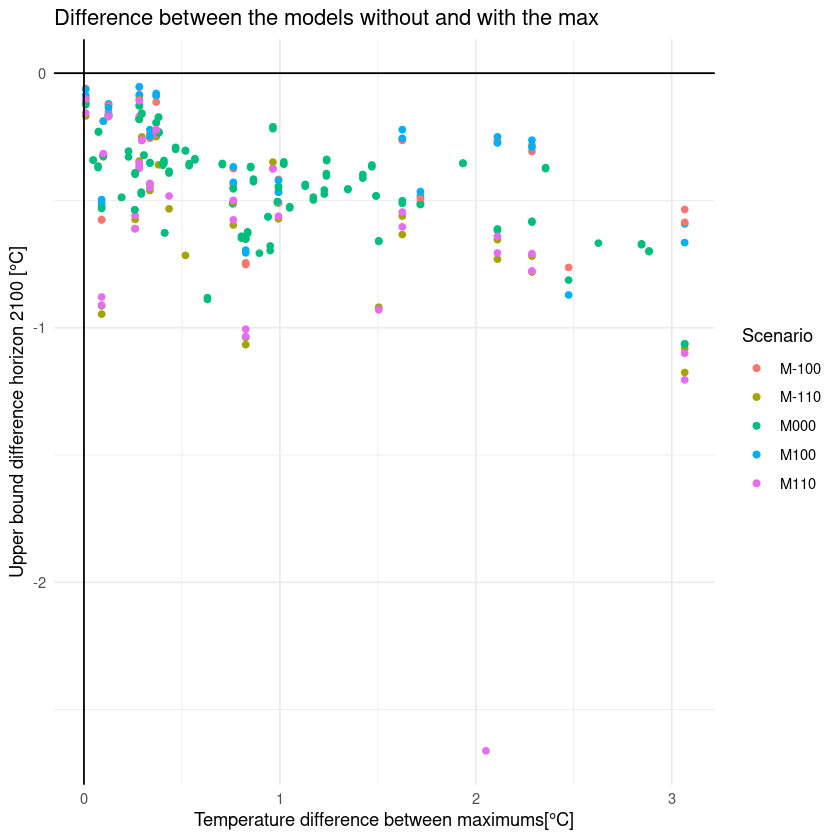

In [41]:
ggplot() +
  geom_point(aes(x=var, y=return_level_diff, color=ns_model), 
             data = ns_model_GMST_diff_no_max.gev.rl) + 
  geom_point(aes(x=var, y=return_level_diff, color=ns_model), 
             data = ns_model_EMST_diff_no_max.gev.rl) + 
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  #geom_point(aes(x=ns_model_GMST_no_hist.gev.params$r2, y=ns_model_GMST_no_hist.gev.rl$return_level, color='No', ns_mod='M110')) + 
  #ylim(-10,0)+
  labs(x="Temperature difference between maximums[°C]", 
       y='Upper bound difference horizon 2100 [°C]', 
       color='Scenario',
       shape='Covariate',
       title='Difference between the models without and with the max')+
  #facet_wrap(~scenario) +
  theme_minimal()
#ggsave(paste(fig_path,"return_level_diff_no_max_original.png", sep=""), width=6, height=4)

In [42]:
TX_adjust_stations_diff_max_mutate = TX_adjust_stations_diff_max %>% 
  mutate(diff_to_max = floor(var)+0.5)

#### GMST ####
TX_adjust_stations_max_mutate_GMST = merge(TX_adjust_stations_max, ns_model_GMST_no_max.evol%>%select(station, CMIP_model, year, scenario, station, upper_bound, ns_model), by = c('station', 'CMIP_model', 'year', 'scenario'))
TX_adjust_stations_max_mutate_GMST = merge(TX_adjust_stations_max_mutate_GMST, TX_adjust_stations_diff_max_mutate%>%select(CMIP_model, station, scenario, diff_to_max), by=c('station', 'CMIP_model', 'scenario'))

TX_adjust_stations_max_mutate_GMST = TX_adjust_stations_max_mutate_GMST %>% 
  mutate(below_UB = ifelse(var>upper_bound, 1, 0))

#Compute probability of beeing above the upper bound  
p_above_CMIP_models_GMST = TX_adjust_stations_max_mutate_GMST %>%
  group_by(CMIP_model) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
            n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

p_above_GEV_models_GMST = TX_adjust_stations_max_mutate_GMST %>%
  group_by(ns_model) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
             n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

p_above_scenario_GMST = TX_adjust_stations_max_mutate_GMST %>%
  group_by(scenario) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
             n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

p_above_diff_max_GMST = TX_adjust_stations_max_mutate_GMST %>%
  group_by(diff_to_max) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
            n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

#### EMST ####
TX_adjust_stations_max_mutate_EMST = merge(TX_adjust_stations_max, ns_model_EMST_no_max.evol%>%select(station, CMIP_model, year, scenario, station, upper_bound, ns_model), by = c('station', 'CMIP_model', 'year', 'scenario'))
TX_adjust_stations_max_mutate_EMST = merge(TX_adjust_stations_max_mutate_EMST, TX_adjust_stations_diff_max_mutate%>%select(CMIP_model, station, scenario, diff_to_max), by=c('station', 'CMIP_model', 'scenario'))

TX_adjust_stations_max_mutate_EMST = TX_adjust_stations_max_mutate_EMST %>% 
  mutate(below_UB = ifelse(var>upper_bound, 1, 0))

#Compute probability of beeing above the upper bound  
p_above_CMIP_models_EMST = TX_adjust_stations_max_mutate_EMST %>%
  group_by(CMIP_model) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
            n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

p_above_GEV_models_EMST = TX_adjust_stations_max_mutate_EMST %>%
  group_by(ns_model) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
             n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

p_above_scenario_EMST = TX_adjust_stations_max_mutate_EMST %>%
  group_by(scenario) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
             n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()

p_above_diff_max_EMST = TX_adjust_stations_max_mutate_EMST %>%
  group_by(diff_to_max) %>%
  summarise(p = sum(below_UB)/length(below_UB), 
            n = sum(below_UB), 
            total = length(below_UB)) %>%
  as.data.frame()


Call:
lm(formula = return_level_diff ~ var, data = ns_model_GMST_diff_no_max.gev.rl)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.01429 -0.09449  0.03856  0.14864  0.42285 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.31243    0.03575  -8.739 1.02e-14 ***
var         -0.16338    0.02870  -5.692 7.93e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2725 on 130 degrees of freedom
Multiple R-squared:  0.1995,	Adjusted R-squared:  0.1934 
F-statistic:  32.4 on 1 and 130 DF,  p-value: 7.935e-08


[1] 0.1995215


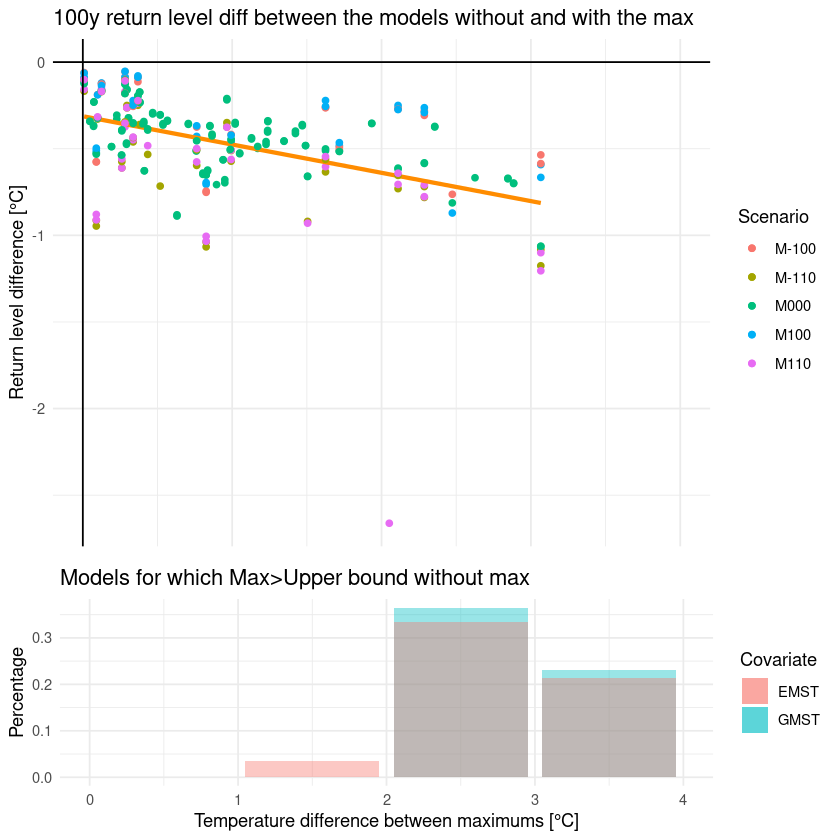

In [43]:
#Linear model
lm_model = lm(return_level_diff ~ var, data=ns_model_GMST_diff_no_max.gev.rl)
summary(lm_model)
print(cor(ns_model_GMST_diff_no_max.gev.rl$return_level_diff, predict(lm_model))^2)

RL_plot = ggplot() +
  geom_point(aes(x=var, y=return_level_diff, color=ns_model), 
             data = ns_model_GMST_diff_no_max.gev.rl) + 
  geom_line(aes(ns_model_GMST_diff_no_max.gev.rl$var, predict.lm(lm_model)), size=1.2, color='darkorange') +
  geom_point(aes(x=var, y=return_level_diff, color=ns_model), 
             data = ns_model_EMST_diff_no_max.gev.rl) + 
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +

  #geom_point(aes(x=ns_model_GMST_no_hist.gev.params$r2, y=ns_model_GMST_no_hist.gev.rl$return_level, color='No', ns_mod='M110')) + 
  labs(x="Temperature difference between maximums[°C]", 
       y='Return level difference [°C]', 
       color='Scenario',
       shape='Covariate',
       title='100y return level diff between the models without and with the max')+
  #ylim(-2,0) +
  xlim(0, 4)+
  #facet_wrap(~scenario) +
  theme_minimal()

Histogram_plot = ggplot() +
  geom_bar(aes(x=diff_to_max, y=p, fill='GMST'), alpha =0.4, stat="identity",data=p_above_diff_max_GMST) +
  geom_bar(aes(x=diff_to_max, y=p, fill='EMST'), alpha =0.4, stat="identity",data=p_above_diff_max_EMST) +
  labs(x="Temperature difference between maximums [°C]", 
       y="Percentage", 
       fill="Covariate",
       title = 'Models for which Max>Upper bound without max') +
  xlim(0, 4)+
  theme_minimal()

cowplot::plot_grid(RL_plot+theme(axis.text.x = element_blank(), 
                                 axis.ticks.x = element_blank(), 
                                 axis.title.x = element_blank()), 
                   Histogram_plot, 
                   nrow=2, 
                   rel_heights = c(2,1),
                   labels = c('', 
                              ''))
#ggsave(paste(fig_path,"100y_return_level_2100_diff_no_max_original_GMST_fit_and_histogram_max_sup_UB.png", sep=""), width=7, height=4)

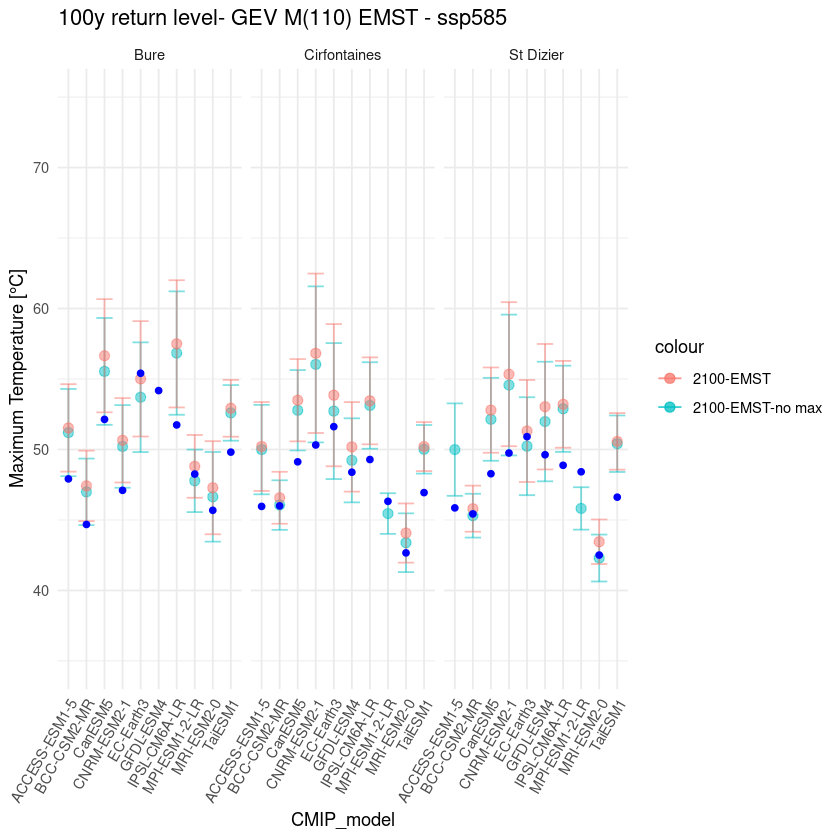

In [44]:
sc = 'ssp585'
ns_mod = 'M110'
ggplot() +
  geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='2100-EMST-no max'), alpha=0.5, data=ns_model_EMST_no_max.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  geom_point(aes(x = CMIP_model, y=return_level, color='2100-EMST-no max'),size=2.5, alpha=0.5, data=ns_model_EMST_no_max.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  
  geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='2100-EMST'), alpha=0.5, data=ns_model_EMST.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  geom_point(aes(x = CMIP_model, y=return_level, color='2100-EMST'), size=2.5, alpha=0.5, data=ns_model_EMST.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  
  #geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='2050-EMST'), alpha=0.5, data=ns_model_EMST_2050.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  #geom_point(aes(x = CMIP_model, y = return_level, color='2050-EMST'), size=2.5, alpha=0.5, data=ns_model_EMST_2050.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  
  #geom_errorbar(aes(x = CMIP_model, ymin = return_level_low, ymax = return_level_high, color='2050-EMST-no max'), alpha=0.5, data=ns_model_EMST_no_max_2050.gev.rl %>% filter(scenario==sc, ns_model==ns_mod))+
  #geom_point(aes(x = CMIP_model, y = return_level, color='2050-EMST-no max'), alpha=0.5, data=ns_model_EMST_no_max_2050.gev.rl %>% filter(scenario==sc,ns_model==ns_mod))+
  geom_point(aes(x=CMIP_model, y=var), color='blue', data = TX_adjust_stations_max %>% filter(scenario==sc)) +
  theme_minimal() +
  ylim(35,75) +
  ylab('Maximum Temperature [°C]') +
  facet_wrap(~station) +
  scale_x_discrete(guide = guide_axis(angle=60)) +
  #scale_color_gradient2(low = 'red', high='firebrick4', mid='yellow', midpoint=2015) +
  ggtitle(paste('100y return level- GEV M(110) EMST - ssp585'))

#ggsave(paste(fig_path,"100y_return_level_most_extreme_value_EMST_M110_ssp585.png", sep=""), height = 6, width = 8)

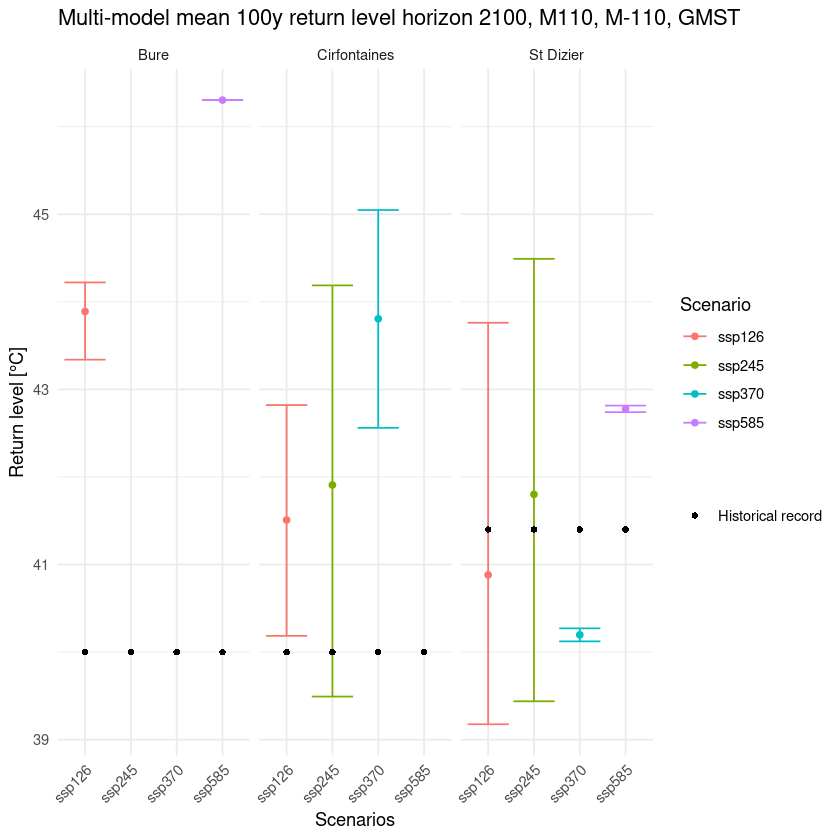

In [45]:
ns_mod = c('M110', 'M-110')

ns_model_GMST_final.gev.rl.mean = ns_model_GMST_final.gev.rl %>% filter(ns_model%in%ns_mod) %>% 
  group_by(station, scenario) %>% 
  summarise(mean_rl = mean(return_level), 
            max_rl = max(return_level), 
            min_rl = min(return_level),
            n = length(return_level),
            .groups='drop')

ggplot() +
  geom_point(aes(x=scenario, y=mean_rl, color=scenario), data = ns_model_GMST_final.gev.rl.mean)+
  geom_errorbar(aes(x=scenario, ymin=min_rl, ymax=max_rl, color=scenario), data = ns_model_GMST_final.gev.rl.mean) +
  geom_point(aes(x=scenario, y=TX, shape='Historical record'), data = TX_record_stations) +
  facet_wrap(~station) +
  #ylim(39,60)+
  labs(x='Scenarios', 
       y='Return level [°C]', 
       colour = 'Scenario', 
       shape='', 
       title='Multi-model mean 100y return level horizon 2100, M110, M-110, GMST') +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  theme_minimal()
#ggsave(paste(fig_path,"100y_return_level_2100_multimodel_mean_M110_M-110_GMST.png", sep=""), width=7, height=4)

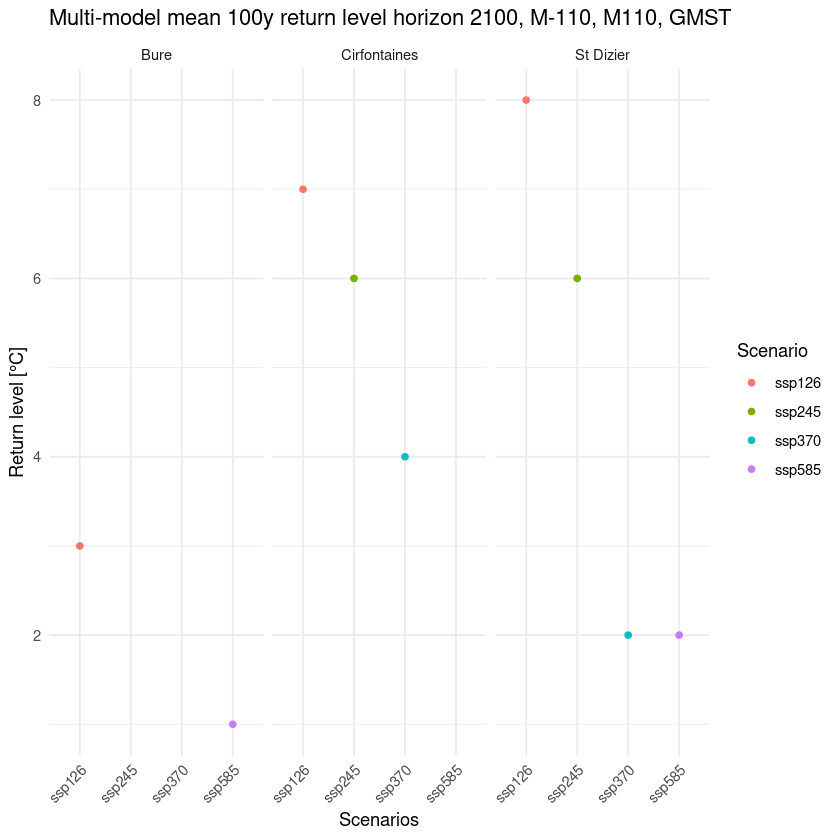

In [46]:
ns_mod = c('M110', 'M-110')

ns_model_GMST_final.gev.rl.mean = ns_model_GMST_final.gev.rl %>% filter(ns_model%in%ns_mod) %>% 
  group_by(station, scenario) %>% 
  summarise(mean_rl = mean(return_level), 
            max_rl = max(return_level), 
            min_rl = min(return_level),
            n = length(return_level),
            .groups='drop')

ggplot() +
  geom_point(aes(x=scenario, y=n, color=scenario), data = ns_model_GMST_final.gev.rl.mean)+
  #geom_errorbar(aes(x=scenario, ymin=min_rl, ymax=max_rl, color=scenario), data = ns_model_GMST_final.gev.rl.mean) +
  #geom_point(aes(x=scenario, y=TX, shape='Historical record'), data = TX_record_stations) +
  facet_wrap(~station) +
  #ylim(35,60)+
  labs(x='Scenarios', 
       y='Return level [°C]', 
       colour = 'Scenario', 
       shape='', 
       title='Multi-model mean 100y return level horizon 2100, M-110, M110, GMST') +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  theme_minimal()
#ggsave(paste(fig_path,"100y_return_level_2100_multimodel_mean_M110_M-110_GMST_no_final.png", sep=""), width=7, height=4)

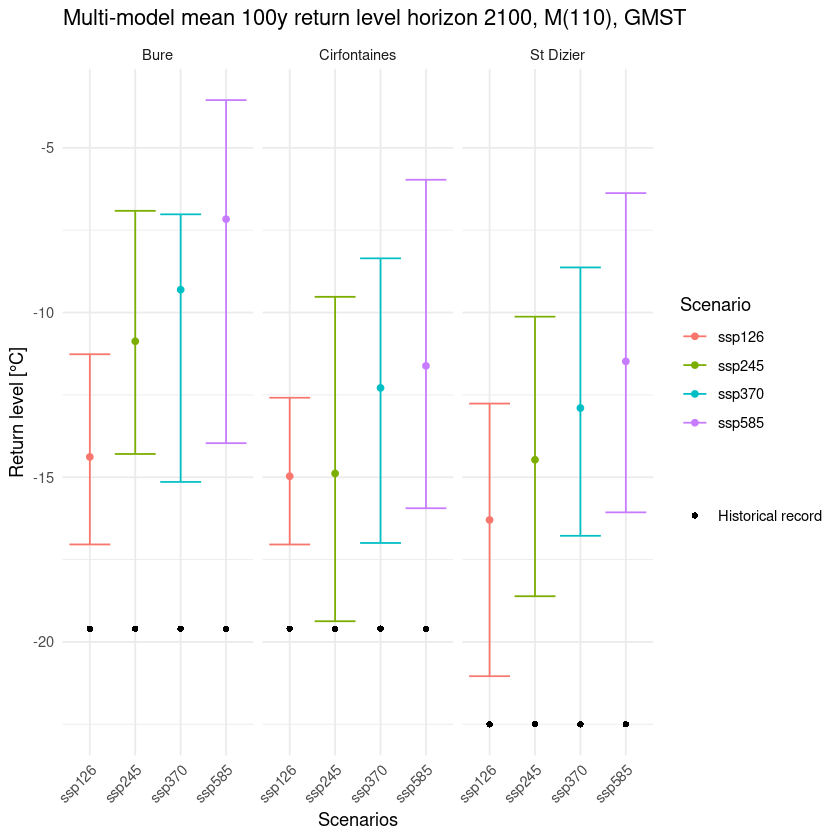

In [47]:
ns_mod = 'M110'

ns_model_tasmin_GMST_no_max.gev.rl.mean = ns_model_tasmin_GMST_final.gev.rl %>% filter(ns_model%in%ns_mod) %>% 
  group_by(station, scenario) %>% 
  summarise(mean_rl = mean(return_level), 
            max_rl = max(return_level), 
            min_rl = min(return_level), 
            .groups='drop')

ggplot() +
  geom_point(aes(x=scenario, y=mean_rl, color=scenario), data = ns_model_tasmin_GMST_no_max.gev.rl.mean)+
  geom_errorbar(aes(x=scenario, ymin=min_rl, ymax=max_rl, color=scenario), data = ns_model_tasmin_GMST_no_max.gev.rl.mean) +
  geom_point(aes(x=scenario, y=TN, shape='Historical record'), data = TN_record_stations) +
  facet_wrap(~station) +
  labs(x='Scenarios', 
       y='Return level [°C]', 
       colour = 'Scenario', 
       shape='', 
       title='Multi-model mean 100y return level horizon 2100, M(110), GMST') +
  scale_x_discrete(guide = guide_axis(angle=45)) +
  theme_minimal()
#ggsave(paste(fig_path,"100y_return_level_2100_multimodel_mean_M110_GMST.png", sep=""), width=7, height=4)